In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [2]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

### Data Cleaning

In [3]:
# df0 = Total and facet scores, and score per question
df00 = pd.read_csv('Indian Risk Survey_Besample_Filtered_12_2024.csv')
df0 = df00.iloc[:, 19:62].copy()
df0.insert(0, "ResponseId",0)
df0["ResponseId"] = df00["ResponseId"].copy()
df0

ResponseId                                                 Q0  \
0    R_4RadSQzbD3kAfEP  Yes, I would like to participate in the study ...   
1    R_4F8RqnI7xnwXmBY  Yes, I would like to participate in the study ...   
2    R_8taN3wUPbeZMxzM  Yes, I would like to participate in the study ...   
3    R_4KT4eUqEbo2q5s9  Yes, I would like to participate in the study ...   
4    R_4TMr0yMiNpsJBr5  Yes, I would like to participate in the study ...   
..                 ...                                                ...   
365  R_47eRbAoGWc5Ttzb  Yes, I would like to participate in the study ...   
366  R_4eWLoP4wkX5K1kl  Yes, I would like to participate in the study ...   
367  R_47rbcPZByLBrZFn  Yes, I would like to participate in the study ...   
368  R_42y9IJJWALsuHPF  Yes, I would like to participate in the study ...   
369  R_8k6D0jzzHCC5X3Z  Yes, I would like to participate in the study ...   

       Q1  Q2                                    Q3  \
0    Male  18  Secondary School (11th to 12th Std.)   
1    Male  41                 Undergraduate Program   
2    Male  20                 Undergraduate Program   
3    Male  18  Secondary School (11th to 12th Std.)   
4    Male  37                 Undergraduate Program   
..    ...  ..                                   ...   
365  Male  48                 Post-Graduate Program   
366  Male  22                 Undergraduate Program   
367  Male  19       Diploma and Vocational Training   
368  Male  28                 Undergraduate Program   
369  Male  25                 Undergraduate Program   

                                                    Q4  \
0                                              Student   
1    Salaried/Employee/Consultant in a sector other...   
2                                              Student   
3                                              Student   
4    Salaried/Employee/Consultant in a sector other...   
..                                                 ...   
365  Salaried/Employee/Consultant in a sector other...   
366  Salaried/Employee/Consultant in a sector other...   
367                                            Student   
368  Salaried/Employee/Consultant in a sector other...   
369  Salaried/Employee/Consultant in a sector other...   

                           Q5_1                          Q6_1  \
0                             4                             7   
1                             6                             9   
2                             3  0 (no investment experience)   
3                             5  0 (no investment experience)   
4                             3                             1   
..                          ...                           ...   
365  0 (unwilling to take risk)                             1   
366                           5                             6   
367                           5                             5   
368                           6                             7   
369    7 (willing to take risk)                             8   

                   Q8_1                Q8_2                Q8_3  \
0                     3                   3                   3   
1                     4                   4                   4   
2    6 (strongly agree)  6 (strongly agree)                   4   
3    6 (strongly agree)  6 (strongly agree)                   4   
4                     4                   5                   5   
..                  ...                 ...                 ...   
365                   4                   5                   4   
366                   5                   5                   4   
367  6 (strongly agree)  6 (strongly agree)  6 (strongly agree)   
368  6 (strongly agree)                   3                   5   
369  6 (strongly agree)                   5                   5   

                      Q8_4                   Q8_5                Q8_6  \
0                        4                      5                   4 

## Demographics

In [4]:
df0["age"] = df0["Q2"]

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )


# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 5,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["nonwinsorised_wealth"] = df0["Q14b.1"]


In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

In [6]:
print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 370

Gender:
Male      219
Female    151

Occupation:
Salaried/Employee/Consultant in a sector other than Finance    167
Student                                                        100
Not employed                                                    50
Entrepreneur/Business Owner in a sector other than Finance      30
Stock analyst                                                   12
Insurance agent, etc                                             7
Retired                                                          3
Venture capital/private equity                                   1

Education:
Undergraduate Program                   183
Post-Graduate Program                   117
Secondary School (11th to 12th Std.)     38
Diploma and Vocational Training          18
Ph.D. and higher                          8
Primary School (up to 10th Std.)          5
M.Phil.                                   1

ISCED:
2    201
1    126
3     43

Income:
INR 500,001 – INR 15,00,00

## Winsorizing Wealth

In [7]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

df0["winsorised_wealth"] = winsorize(np.array(df0["nonwinsorised_wealth"]), limits = [0.1, 0.1], inclusive = [False, False])

In [8]:
df0[["nonwinsorised_wealth", "winsorised_wealth"]].describe()

nonwinsorised_wealth  winsorised_wealth
count          3.700000e+02       3.700000e+02
mean           4.836281e+06       2.292018e+06
std            1.521878e+07       3.318279e+06
min            0.000000e+00       2.300000e+04
25%            1.000000e+05       1.000000e+05
50%            5.000000e+05       5.000000e+05
75%            3.000000e+06       3.000000e+06
max            1.500000e+08       1.000000e+07

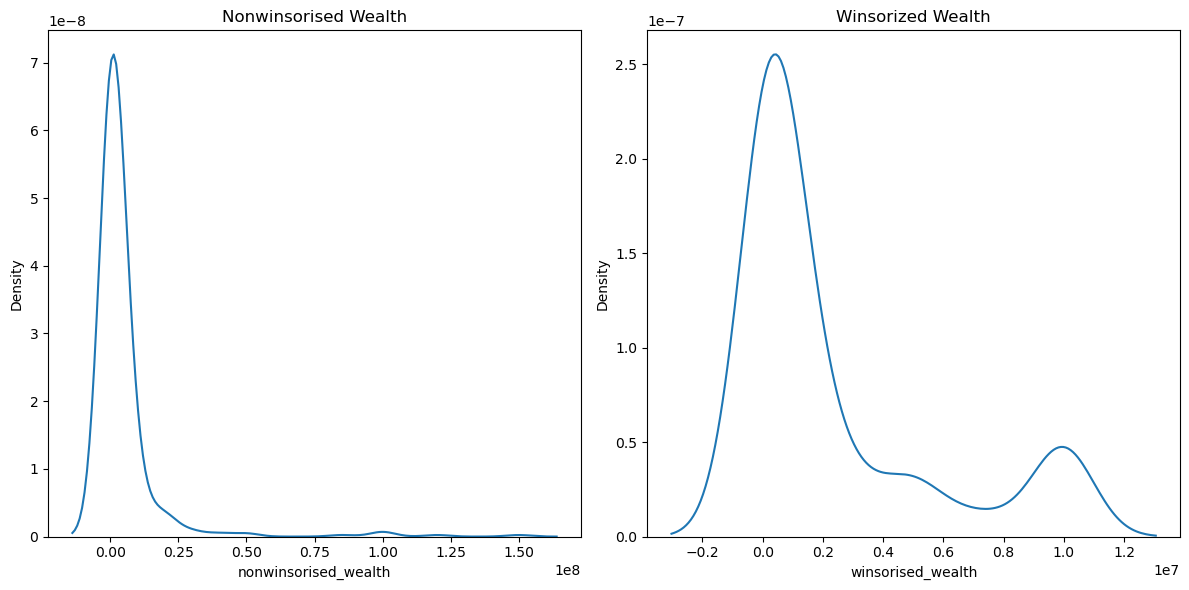

In [9]:
# WEALTH - winsorized, and non winsorized

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.kdeplot(data = df0["nonwinsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
axes[0].set_title('Nonwinsorised Wealth')

sns.kdeplot(data = df0["winsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
axes[1].set_title('Winsorized Wealth')

plt.tight_layout()
plt.show()

In [10]:
# Using winsorised wealth as wealth
df0["wealth"] = df0["winsorised_wealth"].copy()

## Questions

In [11]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df0[ matchCol ] = 0

In [12]:
df0.columns

Index(['ResponseId', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5_1', 'Q6_1', 'Q8_1',
       'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q9b_1',
       'Q9b_4', 'Q9b_5', 'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_9', 'Q11a_1',
       'Q11a_2', 'Q11a_3', 'Q11b', 'Q11c', 'Q11d', 'Q11h', 'Attention Check',
       'Q11i', 'Q12a', 'Q12b', 'Q12c', 'Q13a', 'Q13b', 'Q13c', 'Q13d', 'Q14a',
       'Q14b', 'Q14c', 'Q15a', 'Q14b.1', 'age', 'age_rec', 'isced', 'income',
       'nonwinsorised_wealth', 'winsorised_wealth', 'wealth', 'q8_2_1',
       'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5', 'q8_3', 'q8_4', 'q8_5berlin_1',
       'q8_5london_1', 'q8_5paris_1', 'q8_6', 'q8_7', 'q9_1_1', 'q9_2_1',
       'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1', 'q10_4'],
      dtype='object')

In [13]:
df0["q8_2_1"] = np.where(df0["Q11b"].str.contains("HIV test"), 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b"].str.contains("Fingerprint"), 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b"].str.contains("DNA test"), 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b"].str.contains("Cancer screening test"), 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b"].str.contains("Professional horoscope"), 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [14]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].copy()
df0["q9_2_1"] = df0["Q14b"].copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [15]:
df0["q10_1_1"] = df0["Q13a"].copy()
df0["q10_2_1"] = df0["Q13b"].copy()
df0["q10_3_1"] = df0["Q13c"].copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

## Scoring

In [16]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
                "uncertainty1", "uncertainty2",
                "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
                "graph1", "graph2", "graph3",
                "riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
                "bayesian1"
               ]
df0[scoreColumns] = 0

In [17]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [18]:
df10 = df0.groupby(["ResponseId"]).progress_apply(scoring1)
df10 = df10.reset_index(drop = True).copy()

100%|███████████████████████████████████████████████████████████████████████████████| 370/370 [00:01<00:00, 250.08it/s]


In [19]:
df10

ResponseId                                                 Q0  \
0    R_1YkMM2lMB9aEuVL  Yes, I would like to participate in the study ...   
1    R_401xXJ9E3ZgU9gu  Yes, I would like to participate in the study ...   
2    R_40N8bUn3C0jwGzf  Yes, I would like to participate in the study ...   
3    R_40VyTmJ6i96wUP4  Yes, I would like to participate in the study ...   
4    R_40ZEg7vX3Y7mMQl  Yes, I would like to participate in the study ...   
..                 ...                                                ...   
365  R_4yzFrFYMa7w8nQZ  Yes, I would like to participate in the study ...   
366  R_4zPiSk23ayGvFD4  Yes, I would like to participate in the study ...   
367  R_4zdzjECYeO2A5Ox  Yes, I would like to participate in the study ...   
368  R_8k6D0jzzHCC5X3Z  Yes, I would like to participate in the study ...   
369  R_8taN3wUPbeZMxzM  Yes, I would like to participate in the study ...   

         Q1  Q2                                    Q3  \
0    Female  41                 Undergraduate Program   
1      Male  33                 Undergraduate Program   
2    Female  18                 Undergraduate Program   
3    Female  34                 Post-Graduate Program   
4    Female  31                 Undergraduate Program   
..      ...  ..                                   ...   
365  Female  18  Secondary School (11th to 12th Std.)   
366    Male  70                 Undergraduate Program   
367  Female  19  Secondary School (11th to 12th Std.)   
368    Male  25                 Undergraduate Program   
369    Male  20                 Undergraduate Program   

                                                    Q4  \
0    Salaried/Employee/Consultant in a sector other...   
1                                        Stock analyst   
2                                              Student   
3                                         Not employed   
4                                         Not employed   
..                                                 ...   
365                                            Student   
366  Salaried/Employee/Consultant in a sector other...   
367                                            Student   
368  Salaried/Employee/Consultant in a sector other...   
369                                            Student   

                           Q5_1                          Q6_1  \
0                             3                             3   
1      7 (willing to take risk)                             8   
2    0 (unwilling to take risk)  0 (no investment experience)   
3                             2  0 (no investment experience)   
4                             4                             6   
..                          ...                           ...   
365  0 (unwilling to take risk)  0 (no investment experience)   
366                           4                             6   
367                           4                             2   
368    7 (willing to take risk)                             8   
369                           3  0 (no investment experience)   

                   Q8_1                Q8_2 Q8_3                   Q8_4  \
0                     3                   4    3                      3   
1                     5                   4    5                      5   
2                     3                   3    4                      3   
3                     3                   2    2                      3   
4                     2                   2    2  1 (strongly disagree)   
..                  ...                 ...  ...                    ...   
365  6 (strongly agree)                   5    5                      5   
366                   4                   4    4                      4   
367  6 (strongly agree)                   4    5                      5   
368  6 (strongly agree)                   5    5                      4   
369  6 (strongly agree)  6 (strongly agree)    4  1 (strongly disagree)   

                      Q

In [20]:
def scoring2(survey):
    
    survey["Certainty_5"] = 0
    #survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_14"] = survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
                            # survey["Certainty_5"] + 

    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_14"] / 14 * 100
    
    
    colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_14", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

In [21]:
df11 = scoring2(df10)

In [22]:
df2 = df11.copy()

In [23]:
df2

ResponseId  age  age_rec  isced  income      wealth  Certainty_5  \
0    R_1YkMM2lMB9aEuVL   41        3      2       1     25000.0            0   
1    R_401xXJ9E3ZgU9gu   33        2      2       2  10000000.0            0   
2    R_40N8bUn3C0jwGzf   18        2      2       1     80000.0            0   
3    R_40VyTmJ6i96wUP4   34        2      1       1    500000.0            0   
4    R_40ZEg7vX3Y7mMQl   31        2      2       1    500000.0            0   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4yzFrFYMa7w8nQZ   18        2      3       1     90000.0            0   
366  R_4zPiSk23ayGvFD4   70        4      2       3   7000000.0            0   
367  R_4zdzjECYeO2A5Ox   19        2      3       1    800000.0            0   
368  R_8k6D0jzzHCC5X3Z   25        2      2       5   8000000.0            0   
369  R_8taN3wUPbeZMxzM   20        2      2       1     23000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    2                1           1   
1                0                    2                3           1   
2                0                    2                1           0   
3                1                    3                1           0   
4                0                    2                2           2   
..             ...                  ...              ...         ...   
365              0                    3                2           0   
366              1                    3                2           2   
367              1                    1                3           3   
368              1                    2                1           1   
369              1                    2                2           1   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0          0.0            0.0                 40.0   
1                      0          0.0            0.0                 40.0   
2                      1          0.0            0.0                 40.0   
3                      0          0.0           50.0                 60.0   
4                      0          0.0            0.0                 40.0   
..                   ...          ...            ...                  ...   
365                    0          0.0            0.0                 60.0   
366                    0          0.0           50.0                 60.0   
367                    1          0.0           50.0                 20.0   
368                    0          0.0           50.0                 40.0   
369                    1          0.0           50.0                 40.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
0          33.333333   33.333333                  0.0              4   
1         100.000000   33.333333                  0.0              6   
2          33.333333    0.000000                100.0              4   
3          33.333333    0.000000                  0.0              5   
4          66.666667   66.666667                  0.0              6   
..               ...         ...                  ...            ...   
365        66.666667    0.000000                  0.0              5   
366        66.666667   66.666667                  0.0              8   
367       100.000000  100.000000                100.0              9   
368        33.333333   33.333333                  0.0              5   
369        66.666667   33.333333                100.0              7   

     TotalScore_%  
0       28.571429  
1       42.857143  
2       28.571429  
3       35.714286  
4       42.857143  
..            ...  
365     35.714286  
366     57.142857  
367     64.285714  
368     35.714286  
369     50.000000  

[370 rows x 20 columns]

# GRAPHS

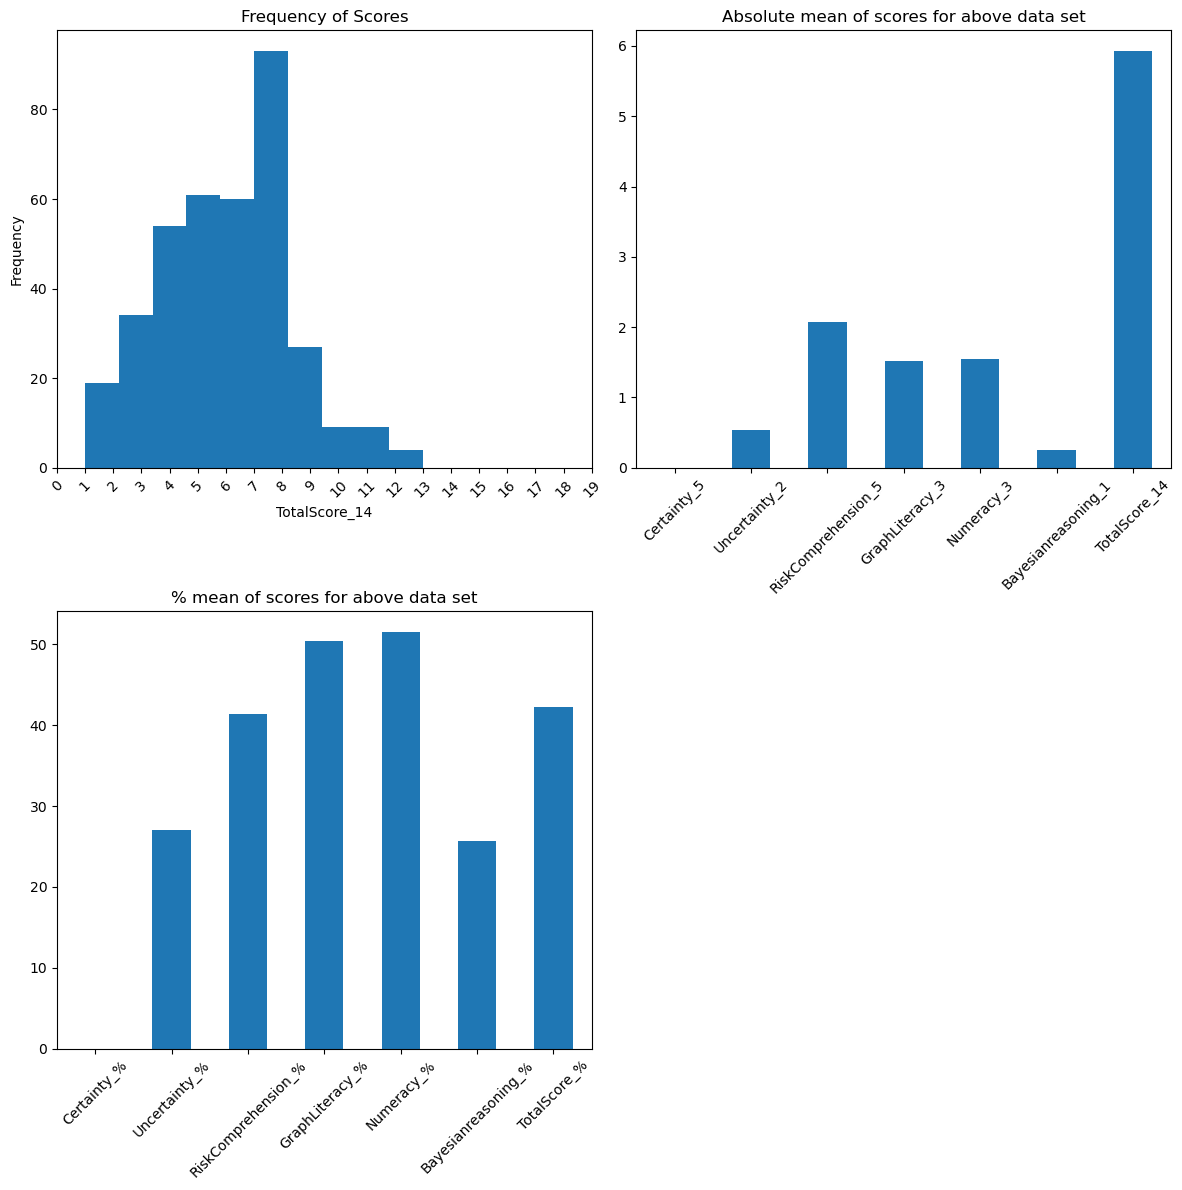

In [24]:
fig, axes = plt.subplots(2, 2, figsize = [12, 12])
fig.subplots_adjust(hspace=1)


# The following graph represents frequency of each data point on "TotalScore_14" or the total score out of 13 questions across the sample.
df2['TotalScore_14'].plot(kind = 'hist', xticks = np.arange(0, 20, step=1), xlabel = 'TotalScore_14', title = 'Frequency of Scores', ax = axes[0, 0] )
axes[0, 0].tick_params(axis = "x", rotation = 45)

# Absolute mean scores for each facet
(df2[['Certainty_5', 'Uncertainty_2', 'RiskComprehension_5','GraphLiteracy_3',
      'Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set', ax = axes[0, 1])
axes[0, 1].tick_params(axis = "x", rotation = 45)

# Normalised mean scores for each facet
df2[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%',
     'Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% mean of scores for above data set', ax = axes[1, 0])
axes[1, 0].tick_params(axis = "x", rotation = 45)

axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# ISCED

In [25]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

In [26]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%',
                      'Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  Uncertainty_%  RiskComprehension_%  Numeracy_%  \
isced                                                                
1              0.0      25.793651            40.634921   53.703704   
2              0.0      25.621891            41.094527   51.243781   
3              0.0      37.209302            44.651163   46.511628   

       GraphLiteracy_%  Bayesianreasoning_%  
isced                                        
1            49.470899            16.666667  
2            51.741294            31.343284  
3            47.286822            25.581395

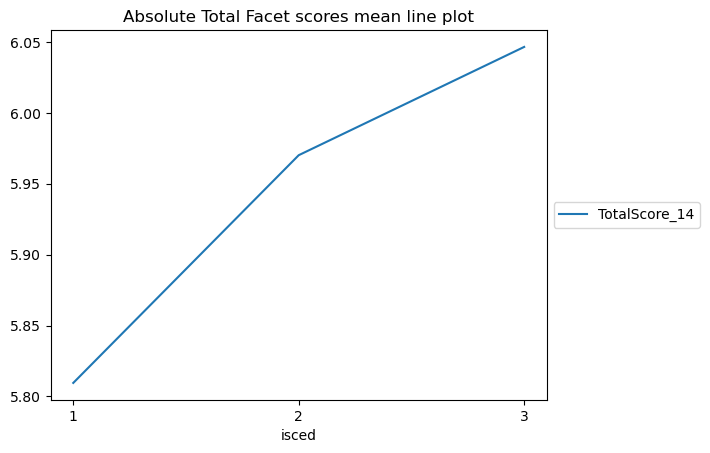

In [27]:
# Absolute Total Facet scores mean line plot from low to high ISCED

df5.groupby('isced')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

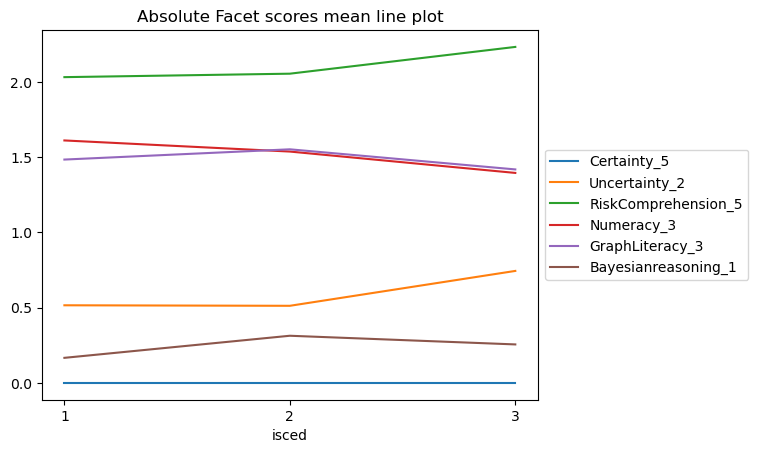

In [28]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

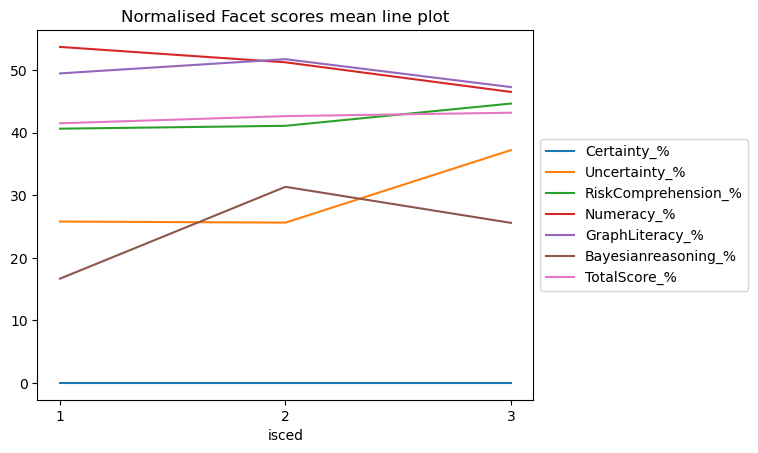

In [29]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

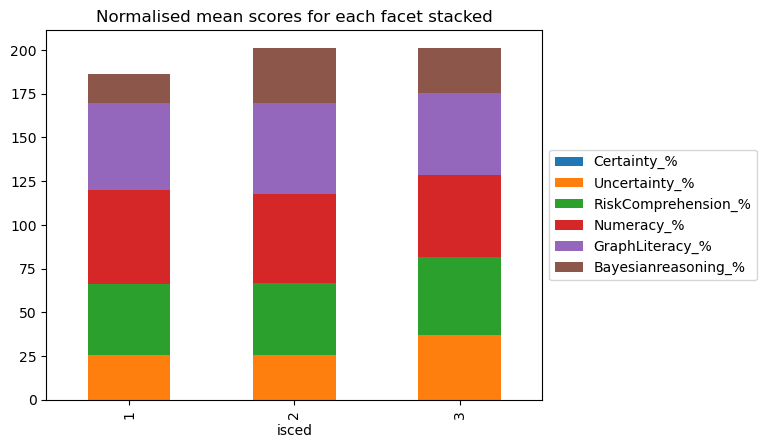

In [30]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

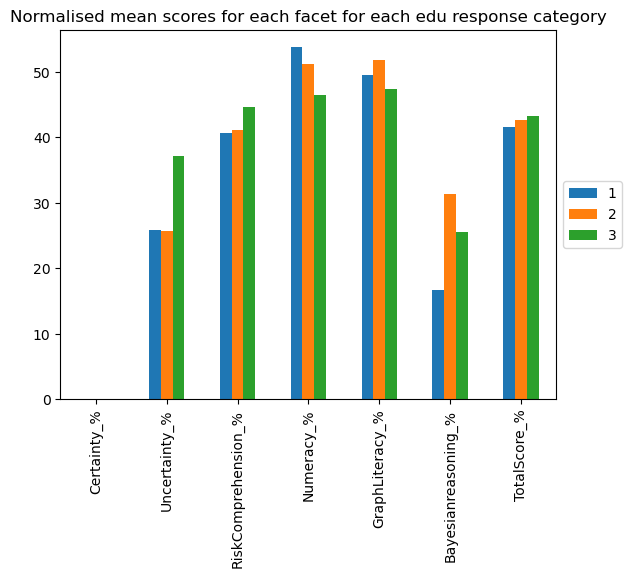

In [31]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_14'>

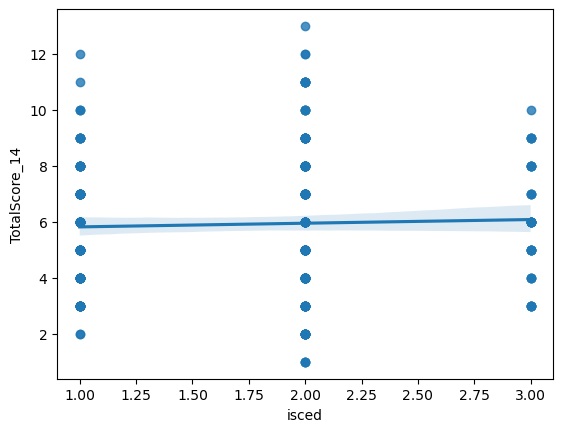

In [32]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_14')

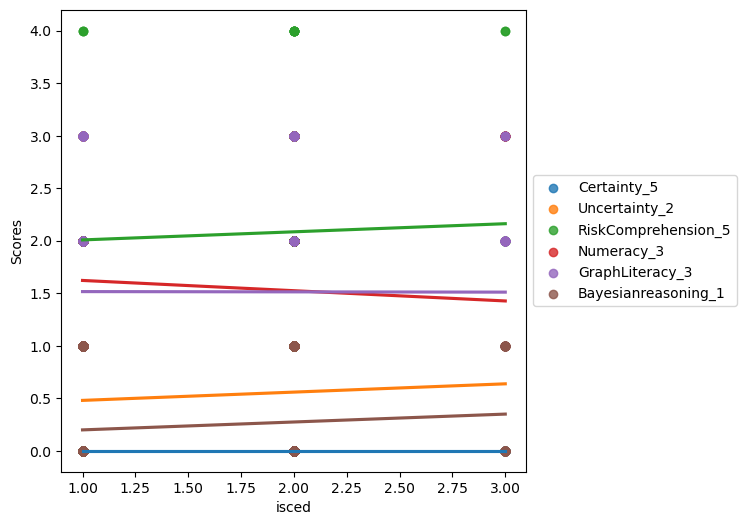

In [33]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax6, label='Certainty_5')
sns.regplot (data = df5, x = 'isced', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax6, label='Uncertainty_2')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_5')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax6, label='Numeracy_3')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_14'>

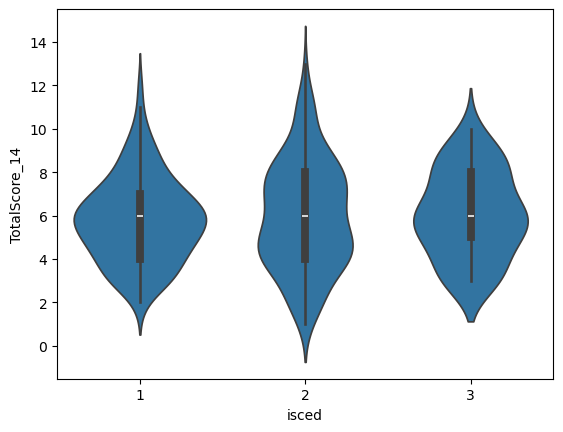

In [34]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_14')

<Axes: xlabel='isced', ylabel='Certainty_5'>

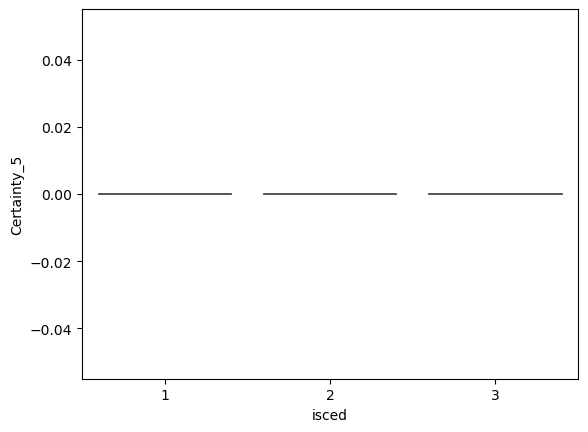

In [35]:
# Violine Plot for Certainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_5')

<Axes: xlabel='isced', ylabel='Uncertainty_2'>

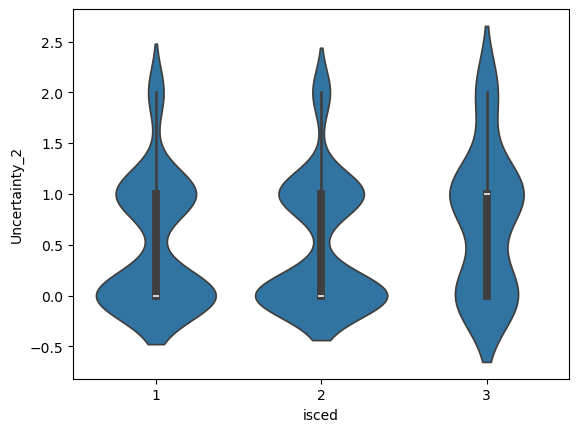

In [36]:
# Violine Plot for Uncertainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Uncertainty_2')

<Axes: xlabel='isced', ylabel='RiskComprehension_5'>

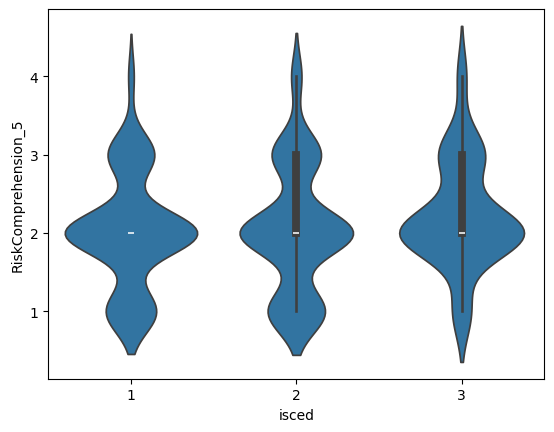

In [37]:
# Violine Plot for RiskComprehension_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_5')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

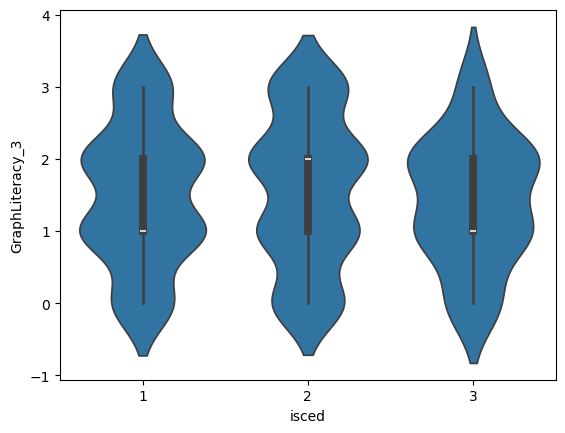

In [38]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_3'>

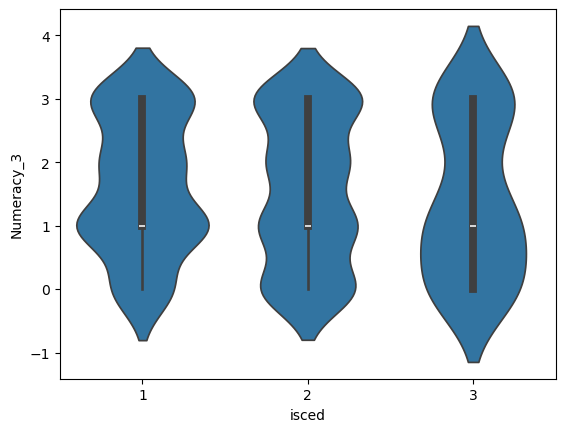

In [39]:
# Violine Plot for Numeracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_3')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

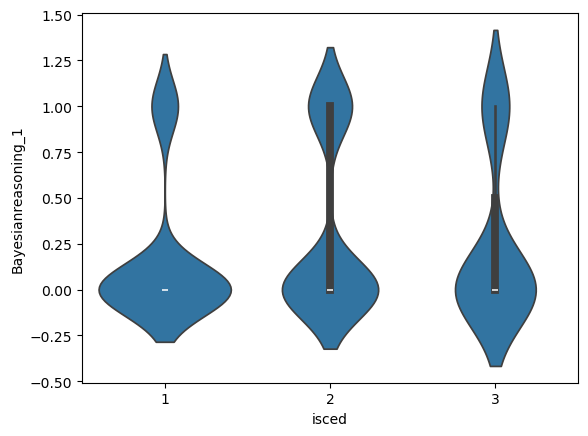

In [40]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

## INCOME

### INCOME VS SCORES

In [41]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

In [42]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1               0.0            41.407035        52.931323   52.261307   
2               0.0            40.566038        51.257862   55.660377   
3               0.0            44.571429        48.571429   40.952381   
4               0.0            44.000000        42.222222   53.333333   
5               0.0            36.000000        24.444444   35.555556   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 28.140704     43.431443  
2                 23.584906     42.587601  
3                 20.000000     40.408163  
4                 26.666667     42.380952  
5                 20.000000     30.000000

In [43]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1              199
2              106
3               35
4               15
5               15

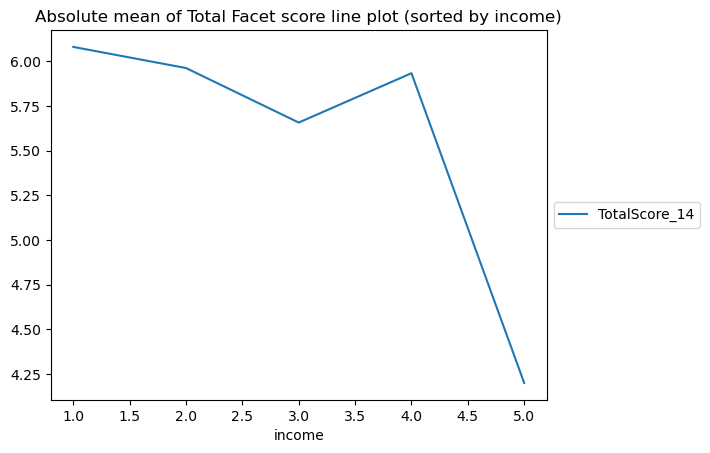

In [44]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

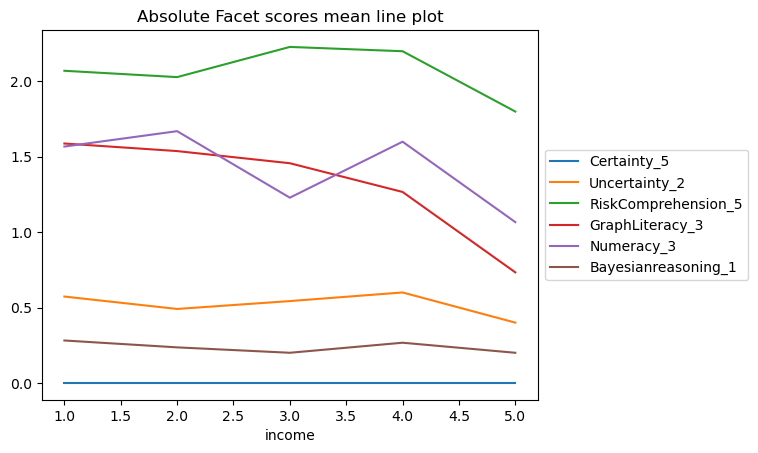

In [45]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

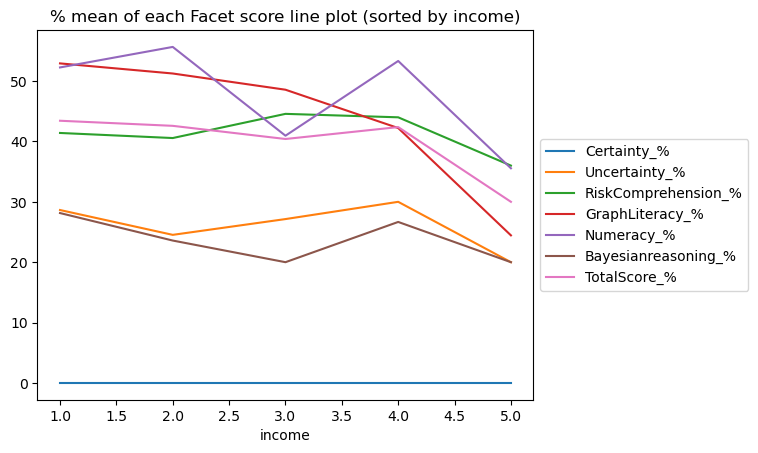

In [46]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = '% mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

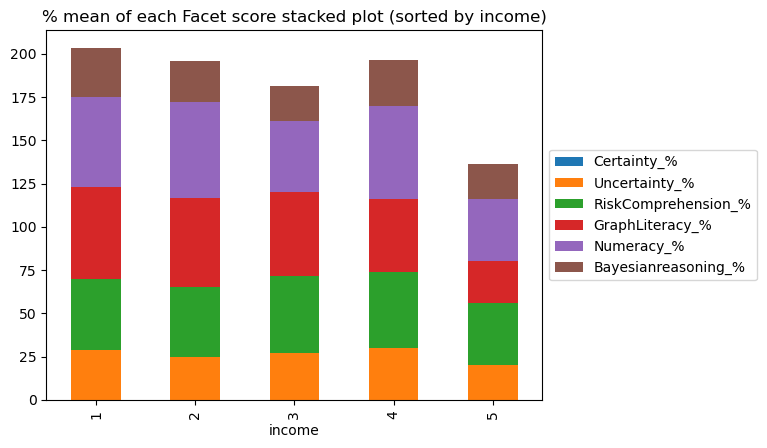

In [47]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

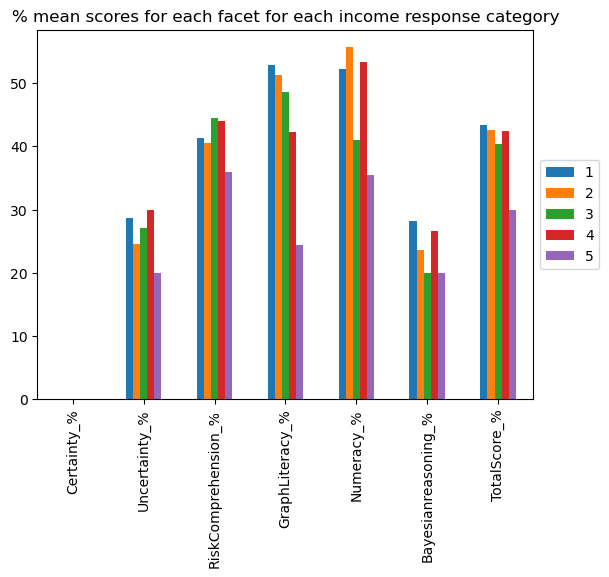

In [48]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each income response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_14'>

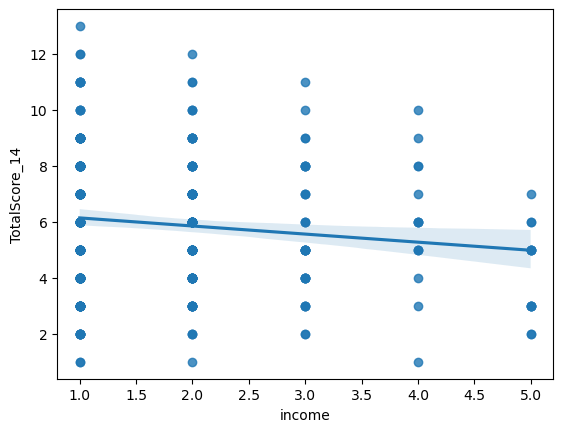

In [49]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_14')

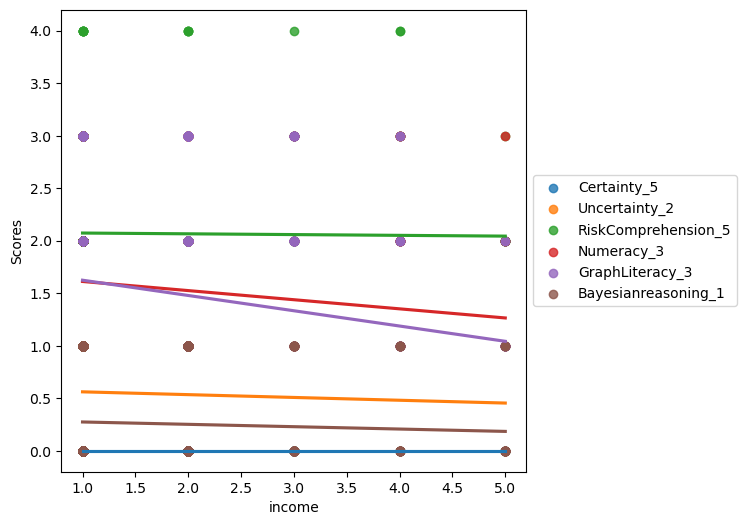

In [50]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax, label='Certainty_5')
sns.regplot (data = df3, x = 'income', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax, label='Uncertainty_2')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_5')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax, label='Numeracy_3')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_14'>

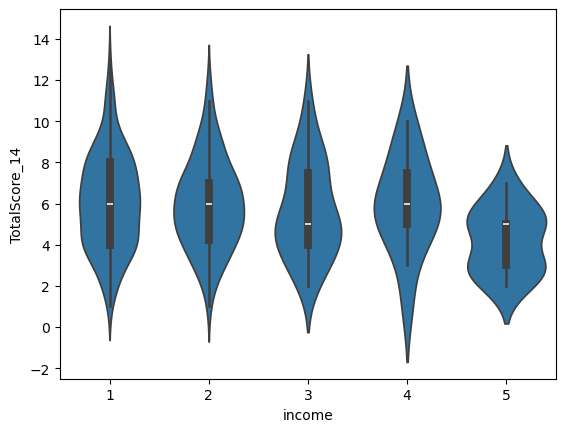

In [51]:
# Violin Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_14')

<Axes: xlabel='income', ylabel='Certainty_5'>

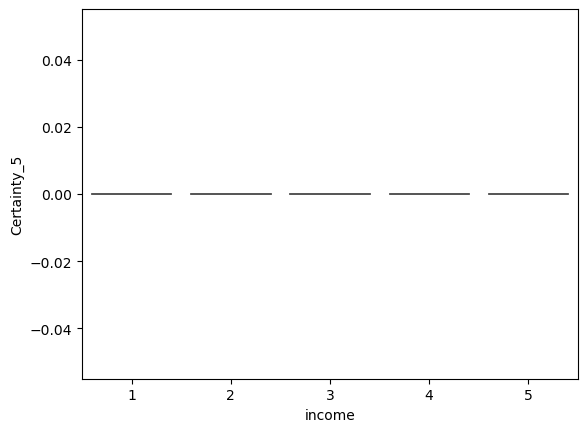

In [52]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_5')

<Axes: xlabel='income', ylabel='Uncertainty_2'>

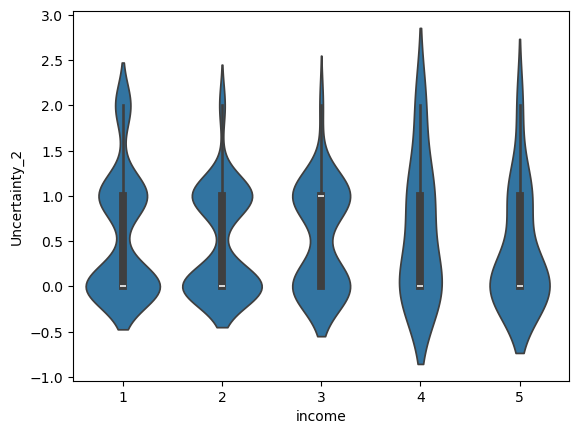

In [53]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Uncertainty_2')

<Axes: xlabel='income', ylabel='RiskComprehension_5'>

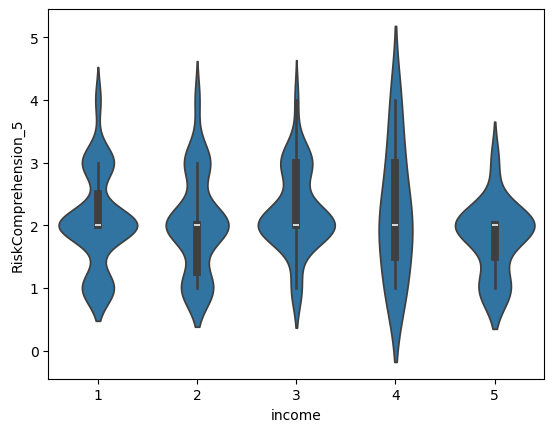

In [54]:
# Violine Plot for RiskComprehension_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_5')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

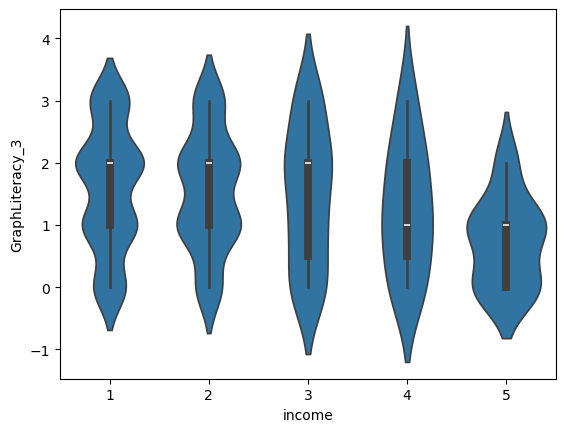

In [55]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_3'>

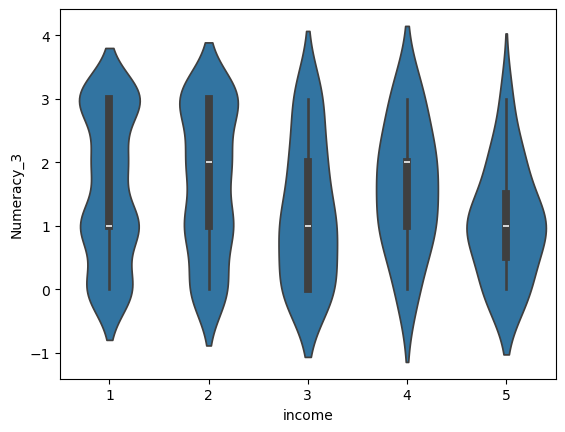

In [56]:
# Violine Plot for Numeracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_3')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

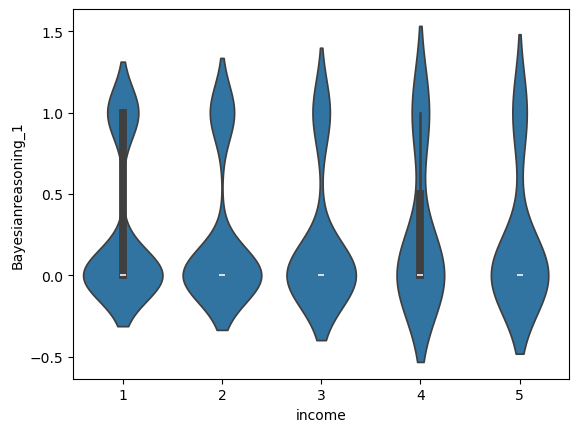

In [57]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

### INCOME vs SCORES w/ ISCED classification

In [58]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  126.000000  126.000000  126.0  126.000000  1.260000e+02        126.0   
mean    33.087302    2.357143    1.0    1.873016  2.664082e+06          0.0   
std      9.354374    0.558058    0.0    1.042951  3.496396e+06          0.0   
min     18.000000    2.000000    1.0    1.000000  2.300000e+04          0.0   
25%     27.000000    2.000000    1.0    1.000000  2.000000e+05          0.0   
50%     31.000000    2.000000    1.0    2.000000  1.000000e+06          0.0   
75%     37.000000    3.000000    1.0    2.000000  4.000000e+06          0.0   
max     70.000000    4.000000    1.0    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     126.000000           126.000000       126.000000  126.000000   
mean        0.515873             2.031746         1.484127    1.611111   
std         0.629083             0.714832         0.952757    1.058091   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             2.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           126.000000        126.0     126.000000           126.000000   
mean              0.166667          0.0      25.793651            40.634921   
std               0.374166          0.0      31.454174            14.296631   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               0.000000          0.0      50.000000            40.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       126.000000  126.000000           126.000000     126.000000   
mean         49.470899   53.703704            16.666667       5.809524   
std          31.758569   35.269684            37.416574       1.950238   
min           0.000000    0.000000             0.000000       2.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max         100.000000  100.000000           100.000000      12.000000   

       TotalScore_%  
count    126.000000  
mean      41.496599  
std       13.930272  
min       14.285714  
25%       28.571429  
50%       42.857143  
75%       50.000000  
max       85.714286

In [59]:
df7.loc[df7['isced']==2].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  201.000000  201.000000  201.0  201.000000  2.010000e+02        201.0   
mean    27.716418    2.144279    2.0    1.686567  2.141604e+06          0.0   
std      8.642579    0.405067    0.0    1.008102  3.253903e+06          0.0   
min     18.000000    2.000000    2.0    1.000000  2.300000e+04          0.0   
25%     22.000000    2.000000    2.0    1.000000  1.000000e+05          0.0   
50%     25.000000    2.000000    2.0    1.000000  5.000000e+05          0.0   
75%     31.000000    2.000000    2.0    2.000000  2.500000e+06          0.0   
max     70.000000    4.000000    2.0    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     201.000000           201.000000       201.000000  201.000000   
mean        0.512438             2.054726         1.552239    1.537313   
std         0.633320             0.801243         1.033686    1.153192   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         0.000000             2.000000         2.000000    1.000000   
75%         1.000000             3.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           201.000000        201.0     201.000000           201.000000   
mean              0.313433          0.0      25.621891            41.094527   
std               0.465047          0.0      31.666012            16.024856   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               1.000000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       201.000000  201.000000           201.000000     201.000000   
mean         51.741294   51.243781            31.343284       5.970149   
std          34.456212   38.439718            46.504694       2.517758   
min           0.000000    0.000000             0.000000       1.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          66.666667   33.333333             0.000000       6.000000   
75%          66.666667  100.000000           100.000000       8.000000   
max         100.000000  100.000000           100.000000      13.000000   

       TotalScore_%  
count    201.000000  
mean      42.643923  
std       17.983984  
min        7.142857  
25%       28.571429  
50%       42.857143  
75%       57.142857  
max       92.857143

In [60]:
df7.loc[df7['isced']==3].describe()

age    age_rec  isced     income        wealth  Certainty_5  \
count  43.000000  43.000000   43.0  43.000000  4.300000e+01         43.0   
mean   22.255814   2.046512    3.0   1.767442  1.904884e+06          0.0   
std     6.959382   0.433891    0.0   1.250471  3.043102e+06          0.0   
min    16.000000   0.000000    3.0   1.000000  2.300000e+04          0.0   
25%    18.000000   2.000000    3.0   1.000000  7.000000e+04          0.0   
50%    19.000000   2.000000    3.0   1.000000  4.000000e+05          0.0   
75%    22.000000   2.000000    3.0   2.000000  1.750000e+06          0.0   
max    46.000000   3.000000    3.0   5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count      43.000000            43.000000        43.000000   43.000000   
mean        0.744186             2.232558         1.418605    1.395349   
std         0.693268             0.684426         0.879192    1.217717   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    0.000000   
50%         1.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            43.000000         43.0      43.000000            43.000000   
mean              0.255814          0.0      37.209302            44.651163   
std               0.441481          0.0      34.663387            13.688514   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0      50.000000            40.000000   
75%               0.500000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count        43.000000   43.000000            43.000000      43.000000   
mean         47.286822   46.511628            25.581395       6.046512   
std          29.306407   40.590571            44.148145       1.987502   
min           0.000000    0.000000             0.000000       3.000000   
25%          33.333333    0.000000             0.000000       5.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000            50.000000       8.000000   
max         100.000000  100.000000           100.000000      10.000000   

       TotalScore_%  
count     43.000000  
mean      43.189369  
std       14.196446  
min       21.428571  
25%       35.714286  
50%       42.857143  
75%       57.142857  
max       71.428571

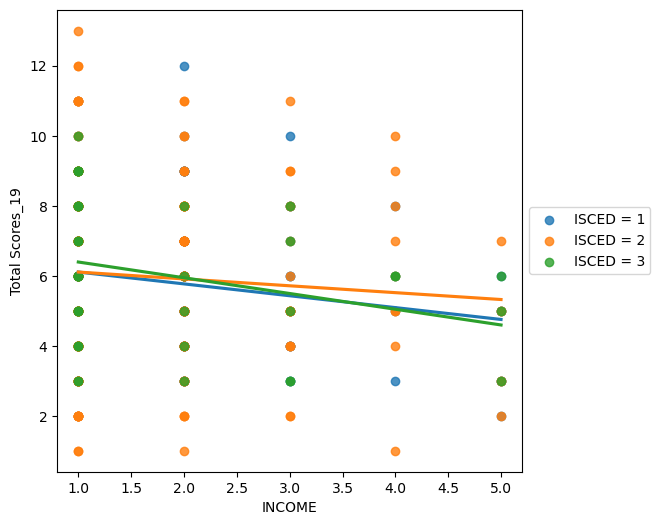

In [61]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

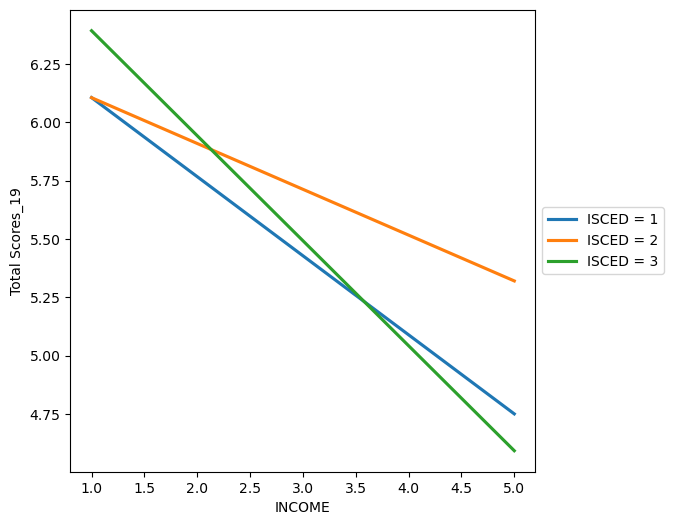

In [62]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

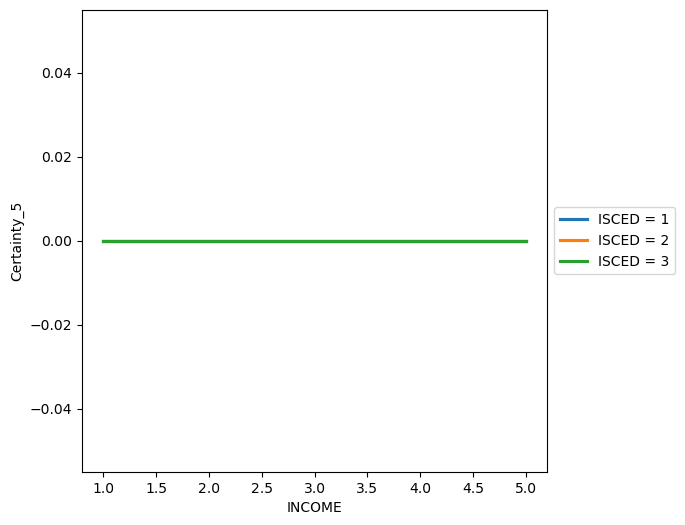

In [63]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

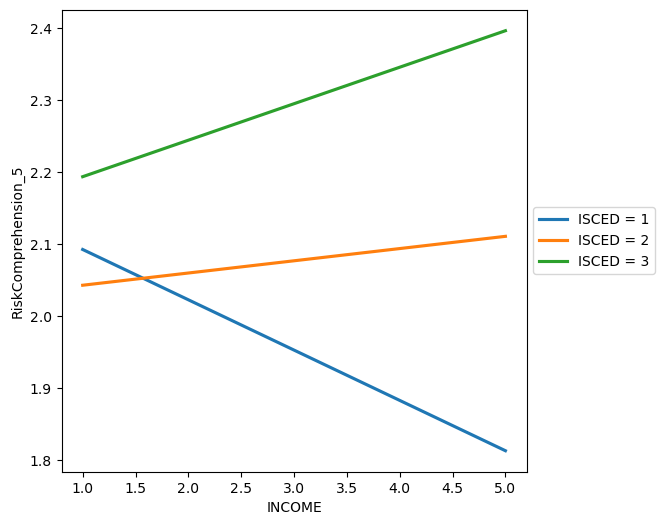

In [64]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

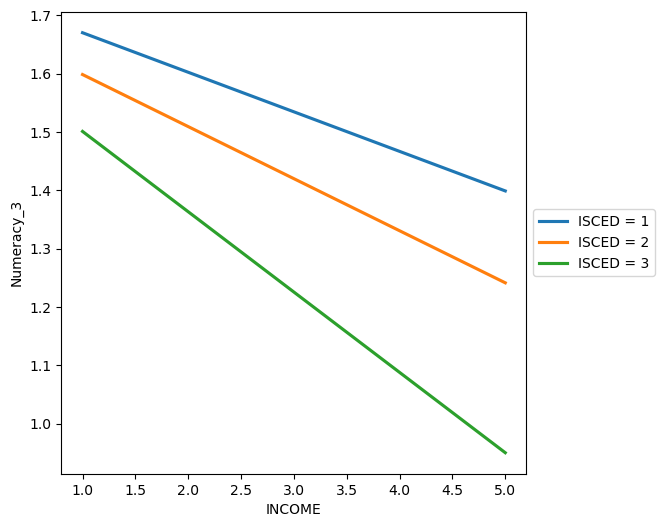

In [65]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

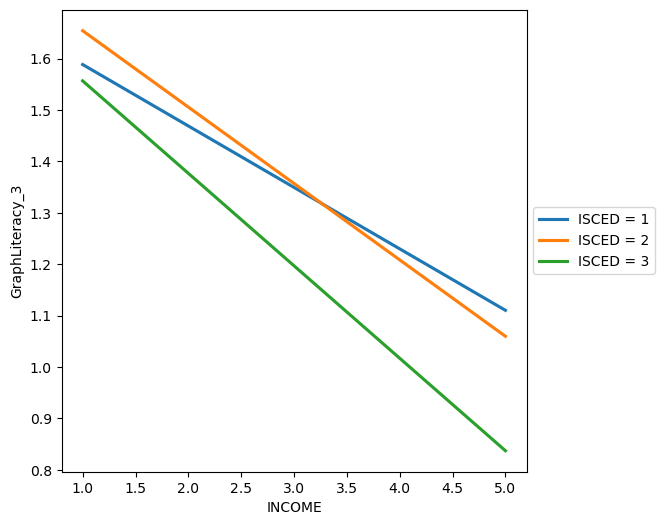

In [66]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

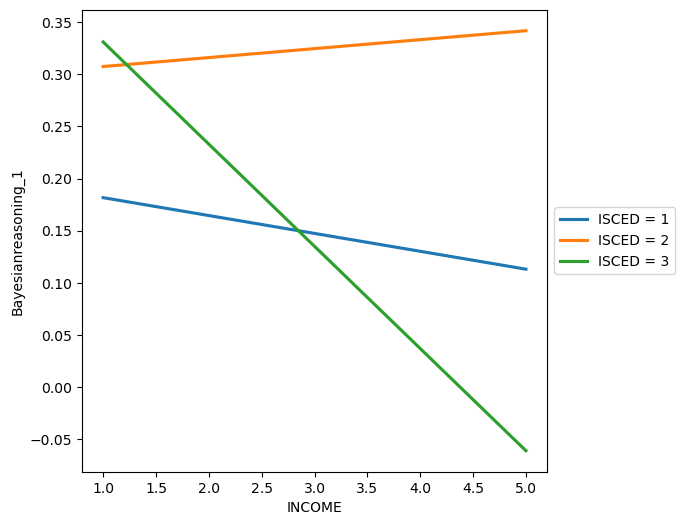

In [67]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### INCOME vs SCORES w/ ISCED and AGE based classification 

In [68]:
df7

ResponseId  age  age_rec  isced  income      wealth  Certainty_5  \
0    R_4XhfVqNhg49zZXe   37        3      1       2   6000000.0            0   
1    R_4FjN0R9SXA0s0G5   53        3      1       2   5000000.0            0   
2    R_4Ph1UNtYnaoPSX7   25        2      1       3    400000.0            0   
3    R_4FVQvDpbnyvqOQY   28        2      1       2   3200000.0            0   
4    R_4PjnTbc2vIjogot   31        2      1       1    200000.0            0   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4fkCPjfYl6UggHL   18        2      3       1   1000000.0            0   
366  R_4K6WL8dnMy7ODbs   18        2      3       5    100000.0            0   
367  R_4ANgmQQx8TBl3kc   21        2      3       1  10000000.0            0   
368  R_4MJAzsNYYA69Y8p   27        2      3       1     23000.0            0   
369  R_4EneslabJXcCOT4   18        2      3       1   3000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    2                1           0   
1                1                    2                1           2   
2                0                    1                0           1   
3                0                    2                0           1   
4                0                    1                0           1   
..             ...                  ...              ...         ...   
365              1                    3                1           3   
366              0                    2                1           0   
367              2                    2                2           3   
368              1                    3                1           0   
369              0                    2                2           3   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0          0.0            0.0                 40.0   
1                      0          0.0           50.0                 40.0   
2                      1          0.0            0.0                 20.0   
3                      0          0.0            0.0                 40.0   
4                      0          0.0            0.0                 20.0   
..                   ...          ...            ...                  ...   
365                    0          0.0           50.0                 60.0   
366                    0          0.0            0.0                 40.0   
367                    1          0.0          100.0                 40.0   
368                    1          0.0           50.0                 60.0   
369                    0          0.0            0.0                 40.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
0          33.333333    0.000000                  0.0              3   
1          33.333333   66.666667                  0.0              6   
2           0.000000   33.333333                100.0              3   
3           0.000000   33.333333                  0.0              3   
4           0.000000   33.333333                  0.0              2   
..               ...         ...                  ...            ...   
365        33.333333  100.000000                  0.0              8   
366        33.333333    0.000000                  0.0              3   
367        66.666667  100.000000                100.0             10   
368        33.333333    0.000000                100.0              6   
369        66.666667  100.000000                  0.0              7   

     TotalScore_%  
0       21.428571  
1       42.857143  
2       21.428571  
3       21.428571  
4       14.285714  
..            ...  
365     57.142857  
366     21.428571  
367     71.428571  
368     42.857143  
369     50.000000  

[370 rows x 20 columns]

In [69]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [70]:
df7.loc[(df7['age_rec']==2)].describe()

age  age_rec       isced      income        wealth  Certainty_5  \
count  300.000000    300.0  300.000000  300.000000  3.000000e+02        300.0   
mean    25.443333      2.0    1.840000    1.730000  2.106699e+06          0.0   
std      4.879839      0.0    0.623723    1.042781  3.209693e+06          0.0   
min     18.000000      2.0    1.000000    1.000000  2.300000e+04          0.0   
25%     21.000000      2.0    1.000000    1.000000  1.000000e+05          0.0   
50%     25.000000      2.0    2.000000    1.000000  5.000000e+05          0.0   
75%     29.000000      2.0    2.000000    2.000000  2.500000e+06          0.0   
max     35.000000      2.0    3.000000    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     300.000000            300.00000       300.000000  300.000000   
mean        0.536667              2.06000         1.536667    1.536667   
std         0.655812              0.77356         0.999325    1.137086   
min         0.000000              1.00000         0.000000    0.000000   
25%         0.000000              2.00000         1.000000    1.000000   
50%         0.000000              2.00000         2.000000    1.000000   
75%         1.000000              3.00000         2.000000    3.000000   
max         2.000000              4.00000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           300.000000        300.0     300.000000           300.000000   
mean              0.273333          0.0      26.833333            41.200000   
std               0.446415          0.0      32.790593            15.471195   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               1.000000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       300.000000  300.000000           300.000000     300.000000   
mean         51.222222   51.222222            27.333333       5.943333   
std          33.310843   37.902879            44.641518       2.354840   
min           0.000000    0.000000             0.000000       1.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          66.666667   33.333333             0.000000       6.000000   
75%          66.666667  100.000000           100.000000       8.000000   
max         100.000000  100.000000           100.000000      13.000000   

       TotalScore_%  
count    300.000000  
mean      42.452381  
std       16.820288  
min        7.142857  
25%       28.571429  
50%       42.857143  
75%       57.142857  
max       92.857143

In [71]:
df7.loc[(df7['age_rec']==3)].describe()

age  age_rec      isced     income        wealth  Certainty_5  \
count  60.000000     60.0  60.000000  60.000000  6.000000e+01         60.0   
mean   41.366667      3.0   1.483333   1.800000  2.752483e+06          0.0   
std     5.108871      0.0   0.624138   0.988064  3.469050e+06          0.0   
min    36.000000      3.0   1.000000   1.000000  2.300000e+04          0.0   
25%    37.000000      3.0   1.000000   1.000000  1.500000e+05          0.0   
50%    40.000000      3.0   1.000000   2.000000  1.000000e+06          0.0   
75%    44.000000      3.0   2.000000   2.000000  5.000000e+06          0.0   
max    54.000000      3.0   3.000000   5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count      60.000000            60.000000        60.000000   60.000000   
mean        0.583333             2.066667         1.450000    1.533333   
std         0.590652             0.709898         0.946447    1.111827   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         1.000000             2.000000         1.000000    1.000000   
75%         1.000000             2.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            60.000000         60.0      60.000000            60.000000   
mean              0.183333          0.0      29.166667            41.333333   
std               0.390205          0.0      29.532611            14.197955   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0      50.000000            40.000000   
75%               0.000000          0.0      50.000000            40.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count        60.000000   60.000000            60.000000      60.000000   
mean         48.333333   51.111111            18.333333       5.816667   
std          31.548247   37.060884            39.020493       1.987176   
min           0.000000    0.000000             0.000000       2.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max         100.000000  100.000000           100.000000      11.000000   

       TotalScore_%  
count     60.000000  
mean      41.547619  
std       14.194117  
min       14.285714  
25%       28.571429  
50%       42.857143  
75%       50.000000  
max       78.571429

In [72]:
df7.loc[(df7['age_rec']==4)].describe()

age  age_rec     isced    income        wealth  Certainty_5  \
count   9.000000      9.0  9.000000  9.000000  9.000000e+00          9.0   
mean   62.888889      4.0  1.444444  2.555556  5.651667e+06          0.0   
std     4.567397      0.0  0.527046  1.509231  4.226837e+06          0.0   
min    57.000000      4.0  1.000000  1.000000  3.500000e+05          0.0   
25%    61.000000      4.0  1.000000  2.000000  5.500000e+05          0.0   
50%    61.000000      4.0  1.000000  2.000000  7.000000e+06          0.0   
75%    65.000000      4.0  2.000000  3.000000  1.000000e+07          0.0   
max    70.000000      4.0  2.000000  5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count       9.000000             9.000000         9.000000         9.0   
mean        0.333333             2.222222         1.333333         2.0   
std         0.500000             0.666667         0.866025         1.0   
min         0.000000             1.000000         0.000000         0.0   
25%         0.000000             2.000000         1.000000         2.0   
50%         0.000000             2.000000         2.000000         2.0   
75%         1.000000             3.000000         2.000000         3.0   
max         1.000000             3.000000         2.000000         3.0   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count             9.000000          9.0       9.000000             9.000000   
mean              0.222222          0.0      16.666667            44.444444   
std               0.440959          0.0      25.000000            13.333333   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               0.000000          0.0      50.000000            60.000000   
max               1.000000          0.0      50.000000            60.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count         9.000000    9.000000             9.000000       9.000000   
mean         44.444444   66.666667            22.222222       6.111111   
std          28.867513   33.333333            44.095855       1.536591   
min           0.000000    0.000000             0.000000       5.000000   
25%          33.333333   66.666667             0.000000       5.000000   
50%          66.666667   66.666667             0.000000       5.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max          66.666667  100.000000           100.000000       9.000000   

       TotalScore_%  
count      9.000000  
mean      43.650794  
std       10.975648  
min       35.714286  
25%       35.714286  
50%       35.714286  
75%       50.000000  
max       64.285714

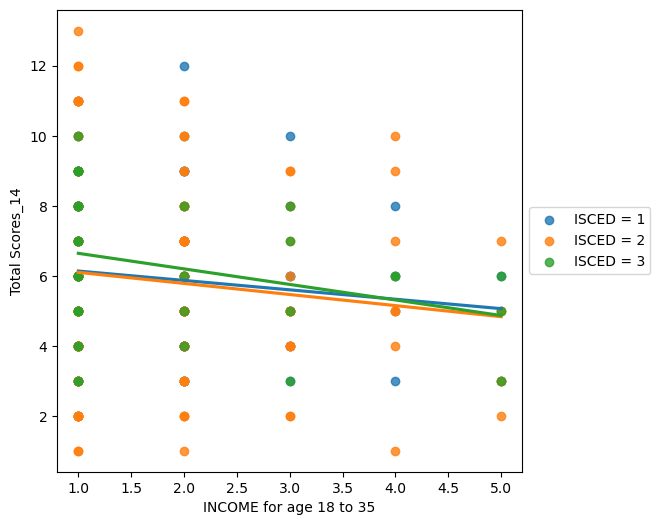

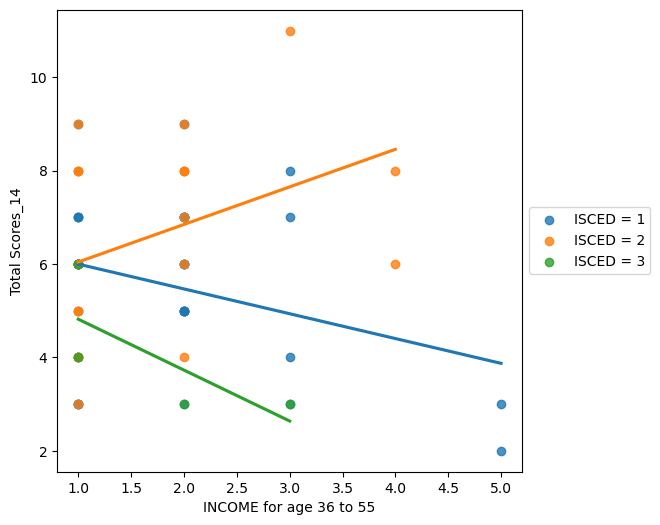

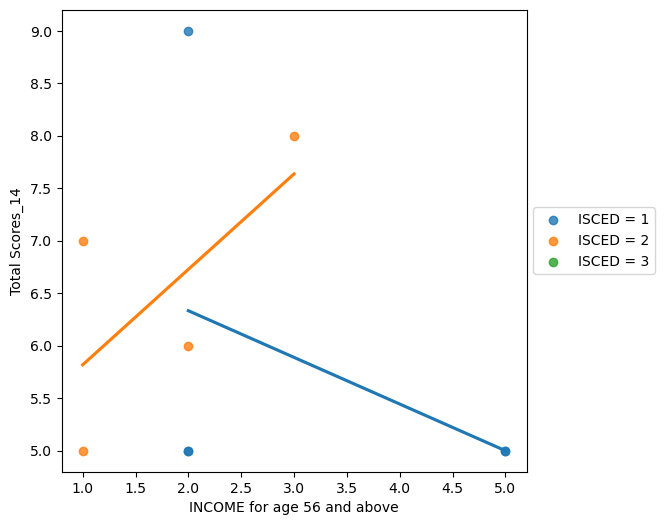

In [73]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

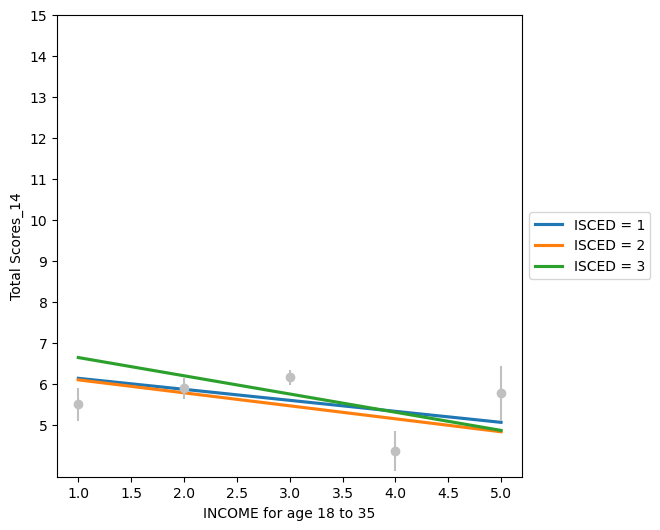

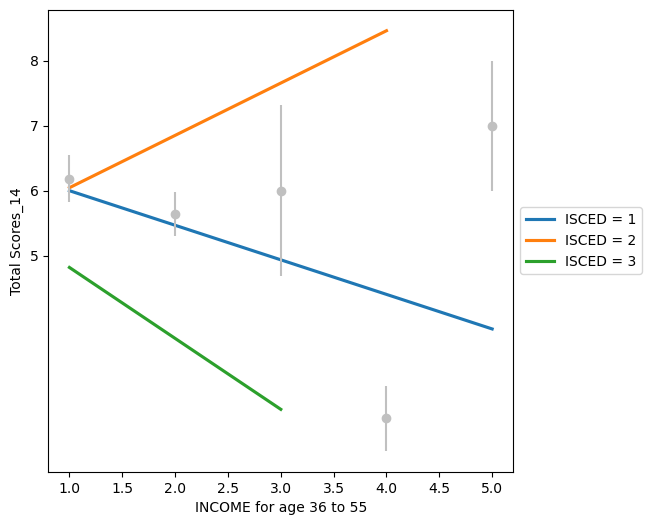

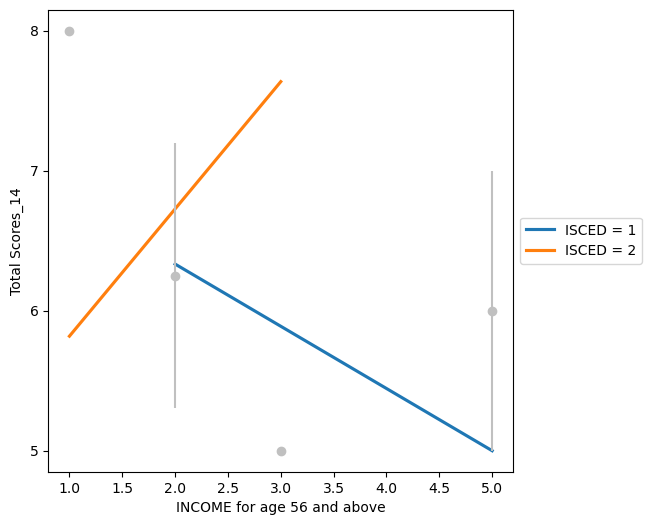

In [74]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

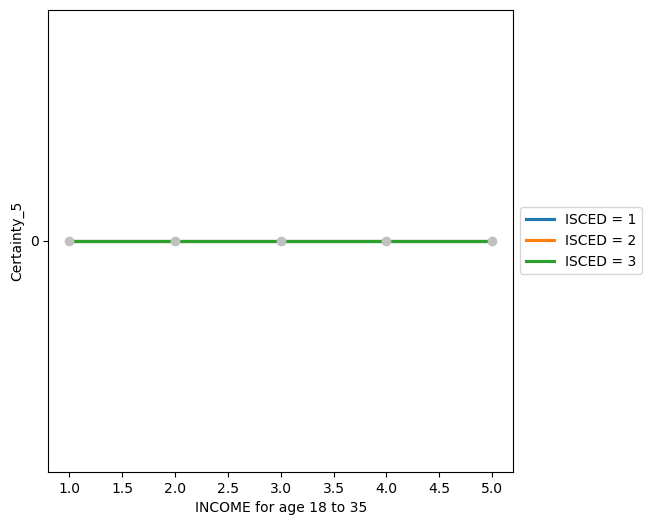

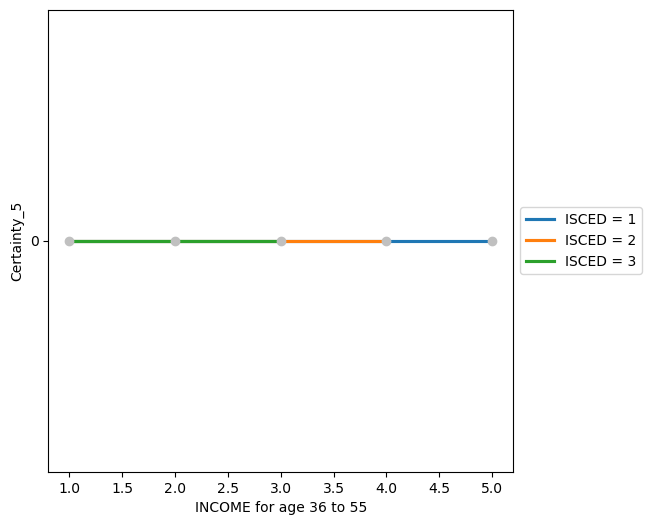

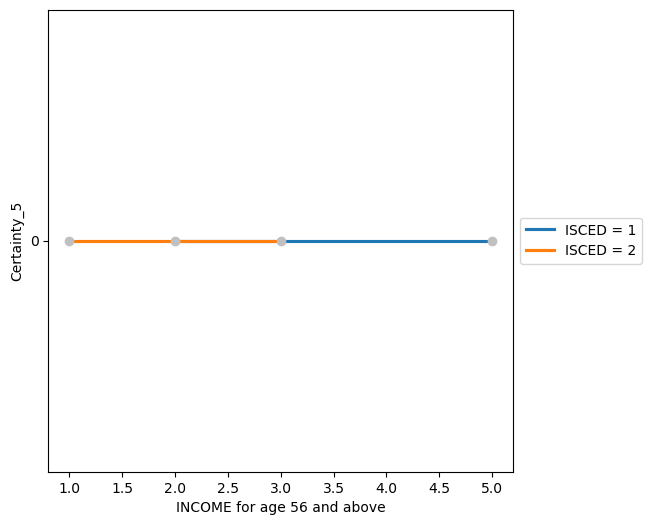

In [75]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

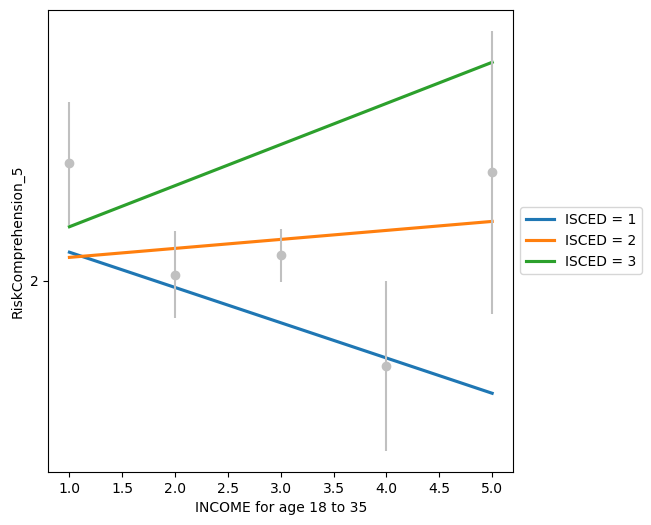

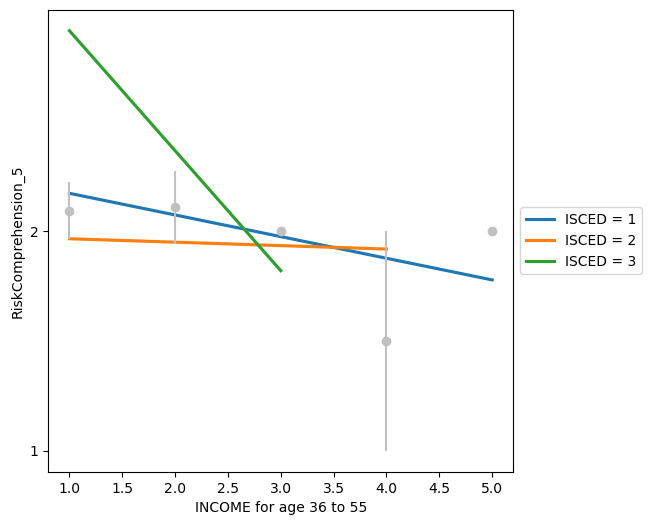

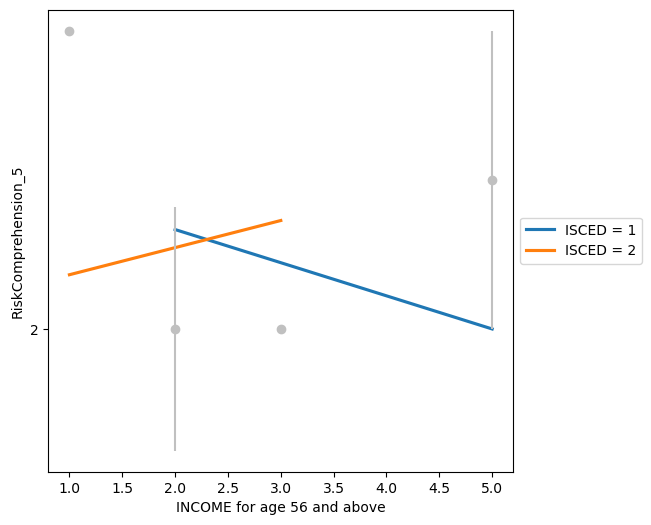

In [76]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

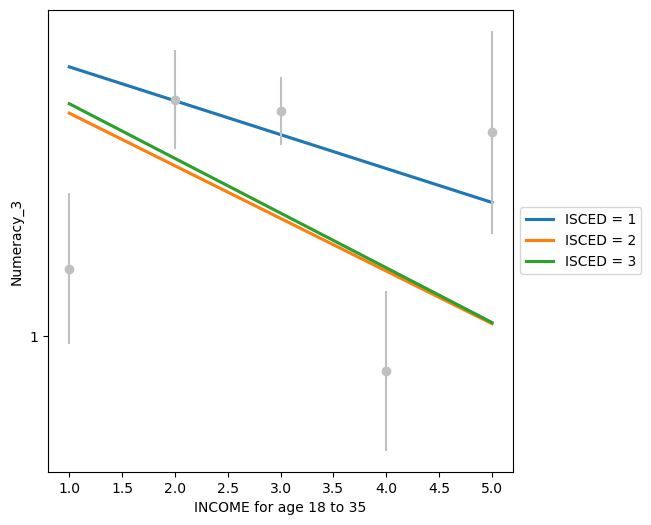

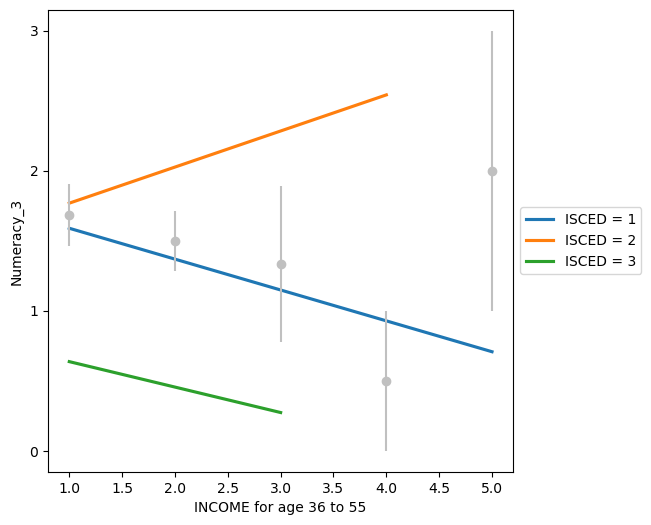

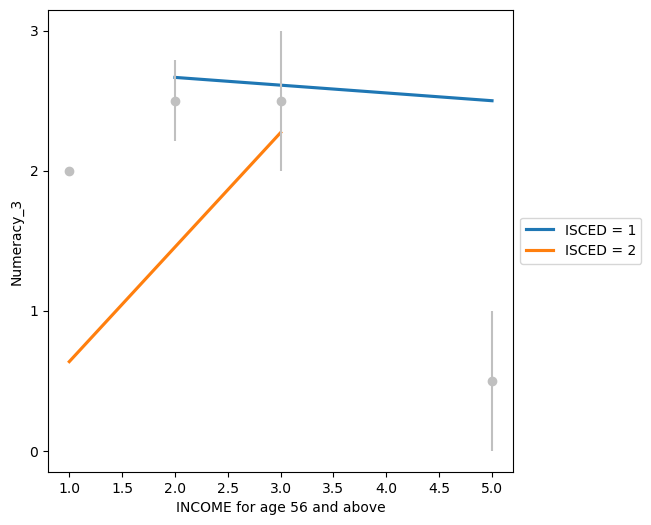

In [77]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

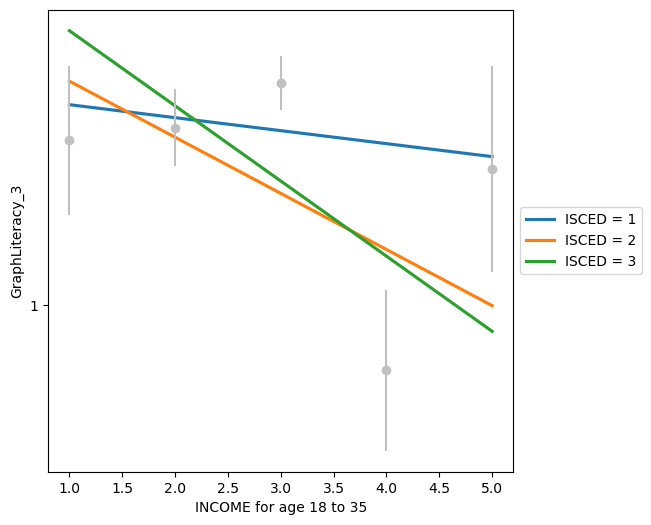

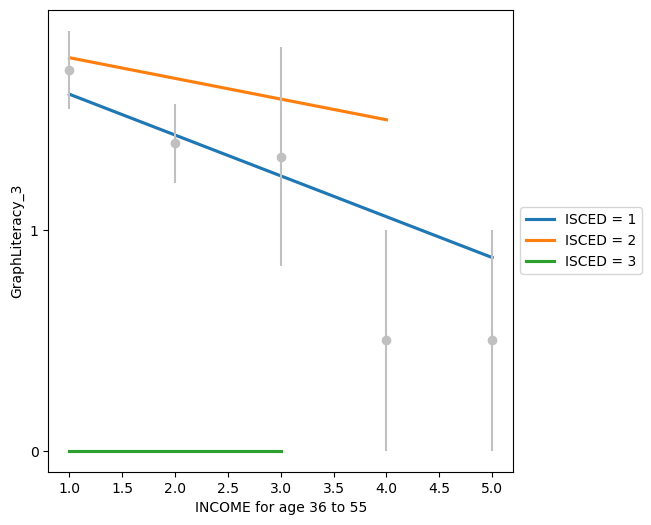

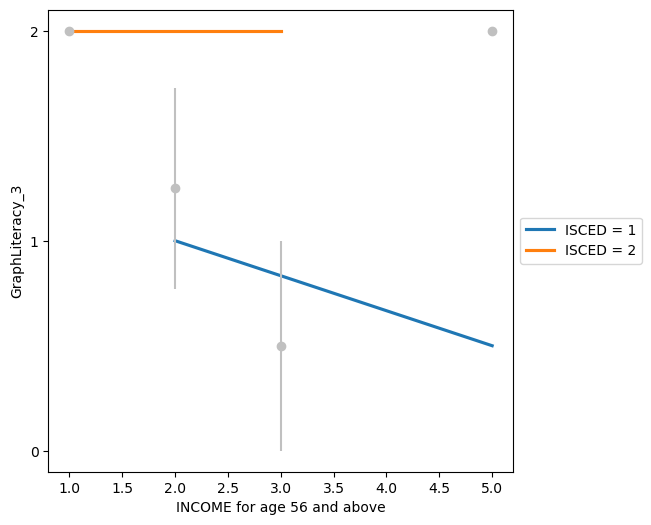

In [78]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

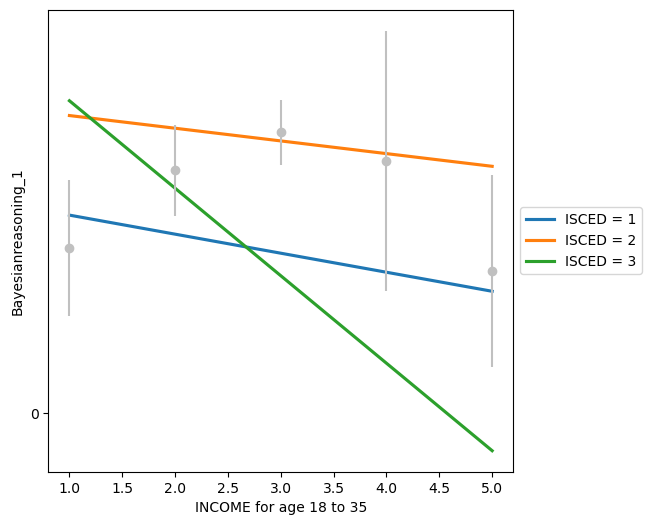

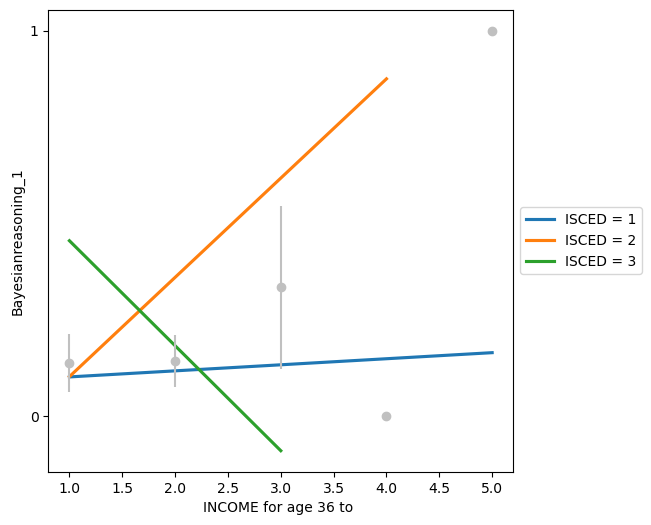

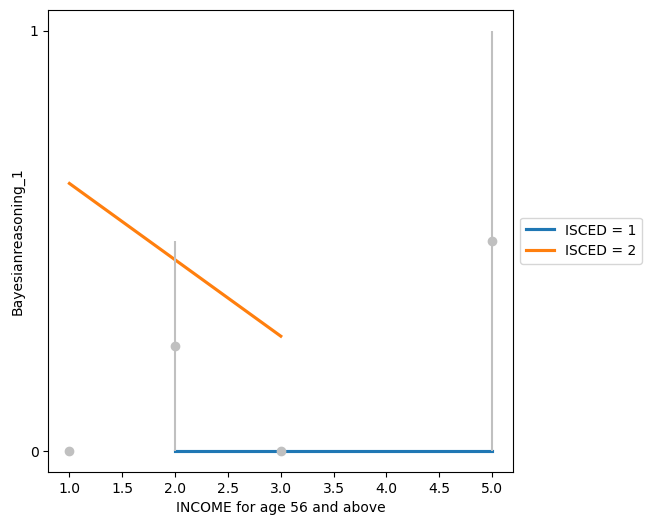

In [79]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [80]:
# Age mean method
# Age_mean

In [81]:
age_m = df2["age"].median()
age_m

27.0

In [82]:
df7["income"].value_counts()

income
1    199
2    106
3     35
5     15
4     15
Name: count, dtype: int64

In [83]:
df7.loc[(df7['age'] < age_m)].describe()

age     age_rec       isced      income        wealth  \
count  175.000000  175.000000  175.000000  175.000000  1.750000e+02   
mean    21.868571    1.988571    2.034286    1.685714  2.013478e+06   
std      2.586411    0.151186    0.614921    1.082022  3.214242e+06   
min     16.000000    0.000000    1.000000    1.000000  2.300000e+04   
25%     20.000000    2.000000    2.000000    1.000000  1.000000e+05   
50%     22.000000    2.000000    2.000000    1.000000  5.000000e+05   
75%     24.000000    2.000000    2.000000    2.000000  1.800000e+06   
max     26.000000    2.000000    3.000000    5.000000  1.000000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count        175.0     175.000000           175.000000       175.000000   
mean           0.0       0.548571             2.068571         1.497143   
std            0.0       0.666683             0.777474         0.964152   
min            0.0       0.000000             1.000000         0.000000   
25%            0.0       0.000000             2.000000         1.000000   
50%            0.0       0.000000             2.000000         2.000000   
75%            0.0       1.000000             3.000000         2.000000   
max            0.0       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  175.000000           175.000000        175.0     175.000000   
mean     1.577143             0.320000          0.0      27.428571   
std      1.136410             0.467815          0.0      33.334154   
min      0.000000             0.000000          0.0       0.000000   
25%      1.000000             0.000000          0.0       0.000000   
50%      2.000000             0.000000          0.0       0.000000   
75%      3.000000             1.000000          0.0      50.000000   
max      3.000000             1.000000          0.0     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           175.000000       175.000000  175.000000           175.000000   
mean             41.371429        49.904762   52.571429            32.000000   
std              15.549487        32.138407   37.880346            46.781468   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333   33.333333             0.000000   
50%              40.000000        66.666667   66.666667             0.000000   
75%              60.000000        66.666667  100.000000           100.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_14  TotalScore_%  
count     175.000000    175.000000  
mean        6.011429     42.938776  
std         2.339045     16.707467  
min         1.000000      7.142857  
25%         4.000000     28.571429  
50%         6.000000     42.857143  
75%         8.000000     57.142857  
max        12.000000     85.714286

In [84]:
df7.loc[(df7['age'] >= age_m)].describe()

age     age_rec       isced      income        wealth  \
count  195.000000  195.000000  195.000000  195.000000  1.950000e+02   
mean    35.230769    2.400000    1.543590    1.825641  2.541990e+06   
std      8.695483    0.577945    0.567048    1.020592  3.397719e+06   
min     27.000000    2.000000    1.000000    1.000000  2.300000e+04   
25%     29.000000    2.000000    1.000000    1.000000  1.825000e+05   
50%     33.000000    2.000000    2.000000    2.000000  8.000000e+05   
75%     38.000000    3.000000    2.000000    2.000000  4.250000e+06   
max     70.000000    4.000000    3.000000    5.000000  1.000000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count        195.0     195.000000           195.000000       195.000000   
mean           0.0       0.533333             2.066667         1.528205   
std            0.0       0.619833             0.746584         1.011773   
min            0.0       0.000000             1.000000         0.000000   
25%            0.0       0.000000             2.000000         1.000000   
50%            0.0       0.000000             2.000000         2.000000   
75%            0.0       1.000000             2.000000         2.000000   
max            0.0       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  195.000000            195.00000        195.0     195.000000   
mean     1.517949              0.20000          0.0      26.666667   
std      1.123065              0.40103          0.0      30.991630   
min      0.000000              0.00000          0.0       0.000000   
25%      1.000000              0.00000          0.0       0.000000   
50%      1.000000              0.00000          0.0       0.000000   
75%      3.000000              0.00000          0.0      50.000000   
max      3.000000              1.00000          0.0     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           195.000000       195.000000  195.000000            195.00000   
mean             41.333333        50.940171   50.598291             20.00000   
std              14.931689        33.725772   37.435487             40.10296   
min              20.000000         0.000000    0.000000              0.00000   
25%              40.000000        33.333333   33.333333              0.00000   
50%              40.000000        66.666667   33.333333              0.00000   
75%              40.000000        66.666667  100.000000              0.00000   
max              80.000000       100.000000  100.000000            100.00000   

       TotalScore_14  TotalScore_%  
count     195.000000    195.000000  
mean        5.846154     41.758242  
std         2.221480     15.867712  
min         1.000000      7.142857  
25%         4.000000     28.571429  
50%         6.000000     42.857143  
75%         7.000000     50.000000  
max        13.000000     92.857143

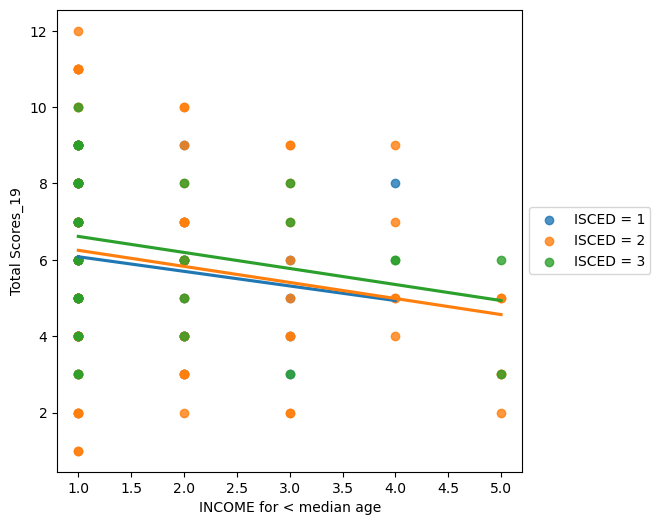

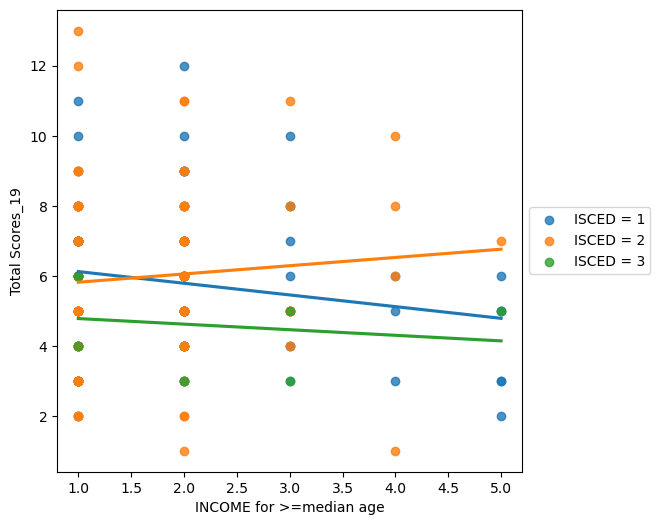

In [85]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] >= age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

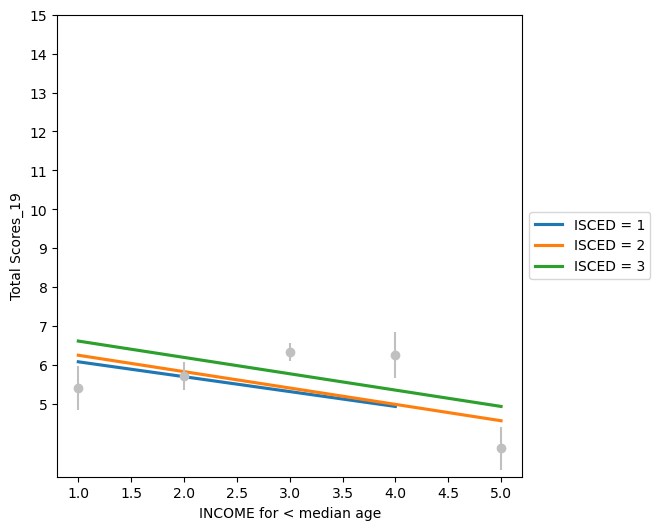

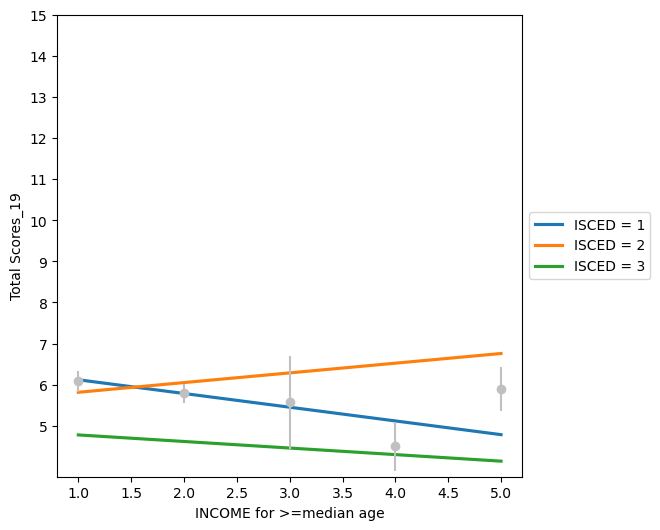

In [86]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

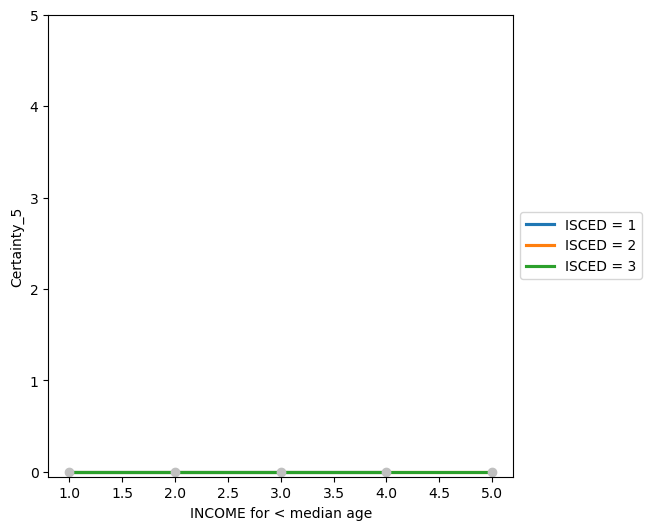

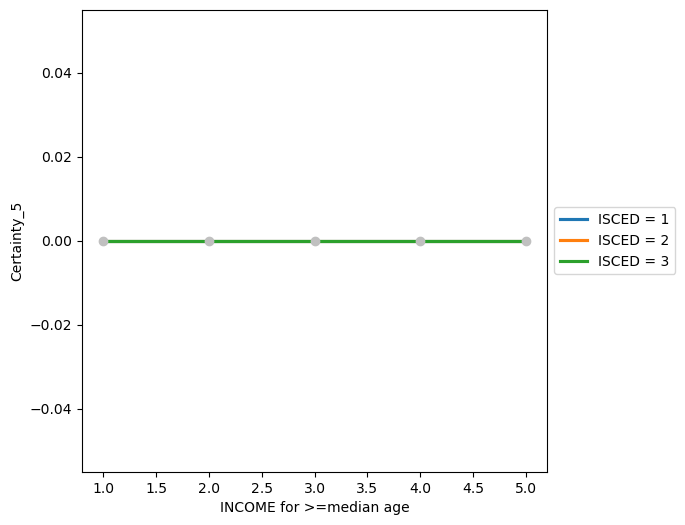

In [87]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

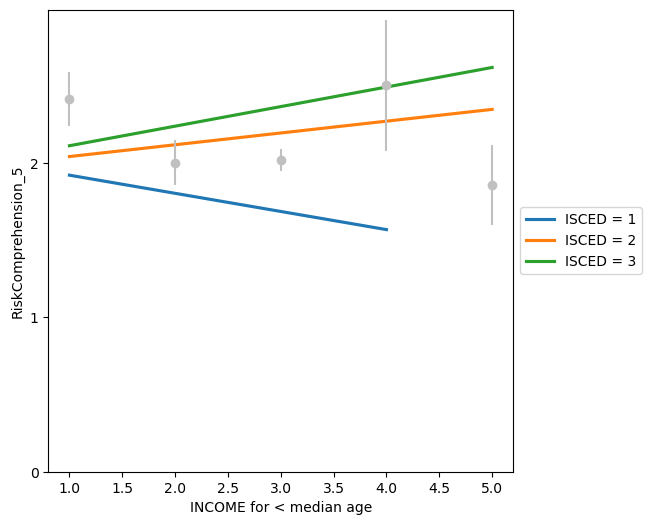

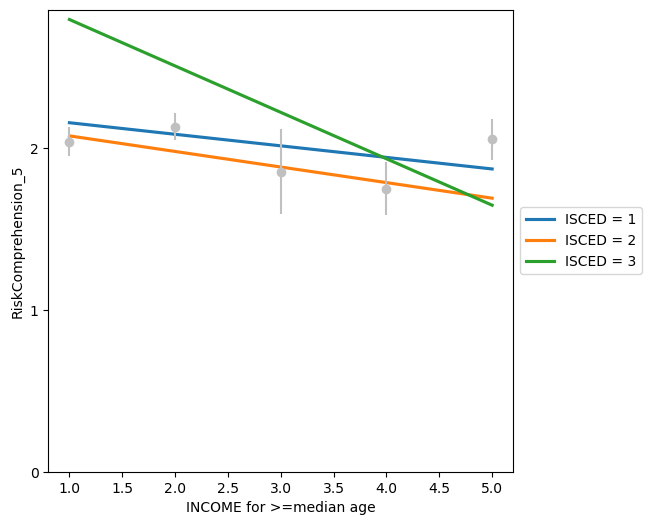

In [88]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

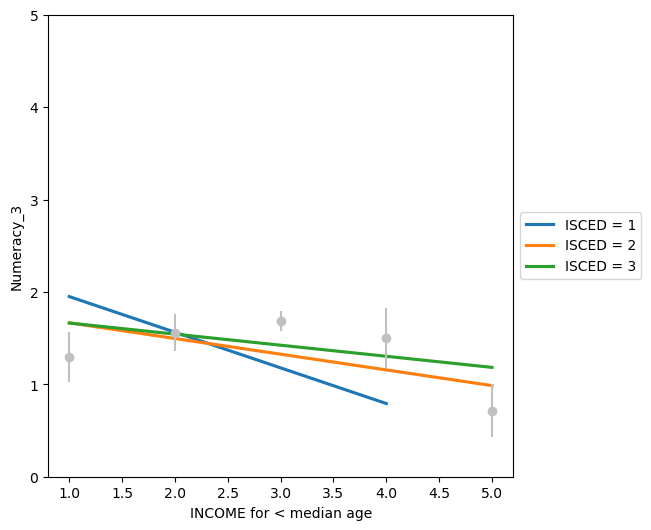

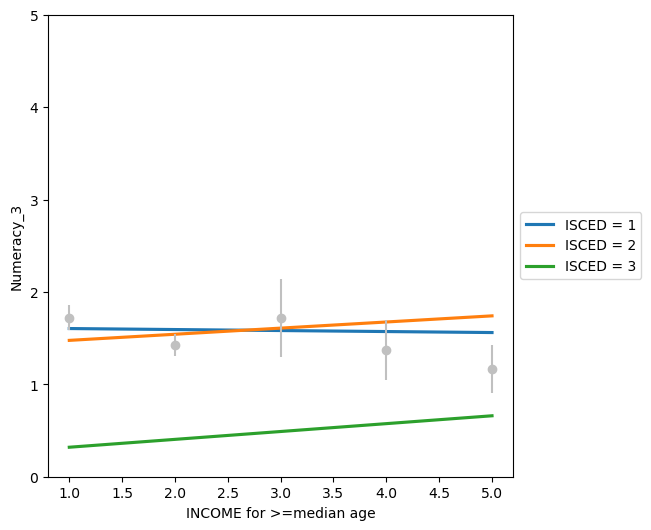

In [89]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='INCOME for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

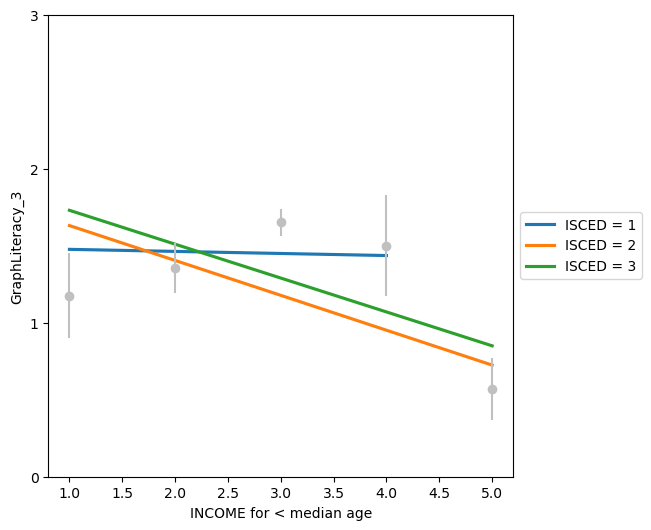

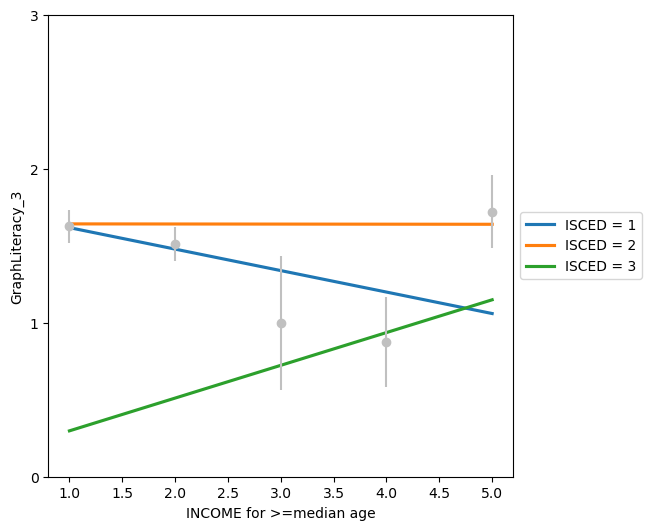

In [90]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

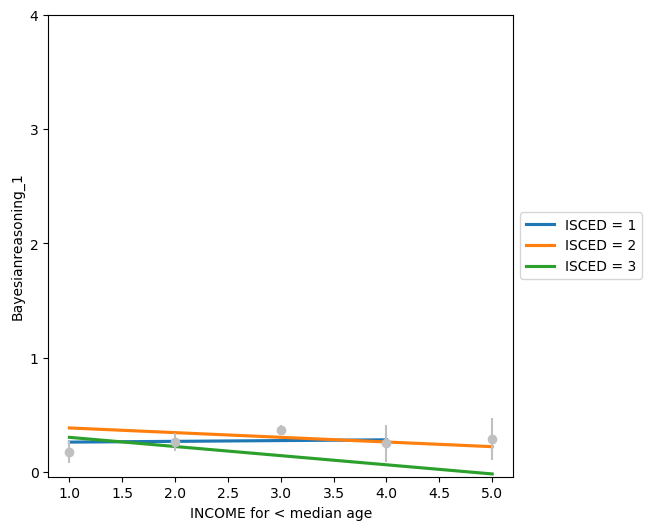

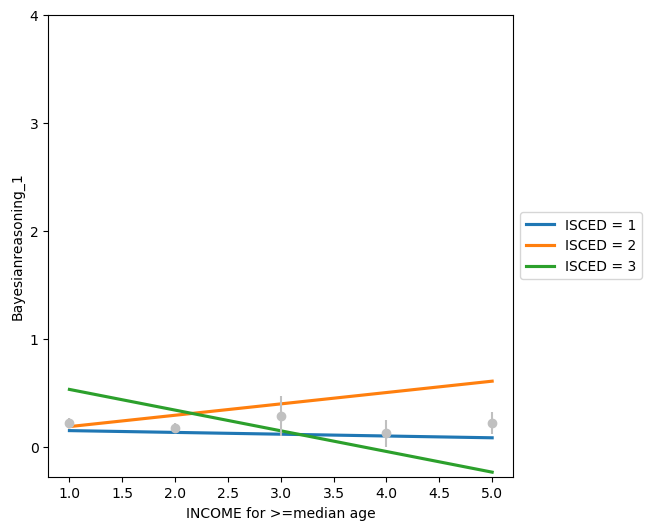

In [91]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

## WEALTH

In [92]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"],q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId  age  age_rec  isced  income      wealth  Certainty_5  \
0    R_4RdvJHWltLGyIlX   25        2      2       2     23000.0            0   
1    R_490q5M87aQkwYfE   21        2      3       1     23000.0            0   
2    R_49CJevI2LFJAPyV   33        2      2       1     23000.0            0   
3    R_4BXfZlfrPGt8mgt   21        2      3       1     23000.0            0   
4    R_4DPGUOAP86yO30R   19        2      3       1     23000.0            0   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4rUt2AHNjUtT3dO   25        2      2       4  10000000.0            0   
366  R_4CIa2n569811FhB   30        2      2       2  10000000.0            0   
367  R_4dn9FLQkkBnMNgq   21        2      2       1  10000000.0            0   
368  R_42Fmxo2od25B7AY   61        4      1       2  10000000.0            0   
369  R_4XgkSFVYD7YAAsS   18        2      2       3  10000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    3                0           1   
1                1                    3                1           0   
2                0                    2                2           0   
3                1                    2                2           1   
4                2                    1                2           1   
..             ...                  ...              ...         ...   
365              1                    1                2           0   
366              1                    2                3           3   
367              0                    2                2           3   
368              0                    2                0           3   
369              0                    2                1           1   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0          0.0            0.0                 60.0   
1                      0          0.0           50.0                 60.0   
2                      0          0.0            0.0                 40.0   
3                      0          0.0           50.0                 40.0   
4                      1          0.0          100.0                 20.0   
..                   ...          ...            ...                  ...   
365                    1          0.0           50.0                 20.0   
366                    0          0.0           50.0                 40.0   
367                    1          0.0            0.0                 40.0   
368                    0          0.0            0.0                 40.0   
369                    0          0.0            0.0                 40.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
0           0.000000   33.333333                  0.0              4   
1          33.333333    0.000000                  0.0              5   
2          66.666667    0.000000                  0.0              4   
3          66.666667   33.333333                  0.0              6   
4          66.666667   33.333333                100.0              7   
..               ...         ...                  ...            ...   
365        66.666667    0.000000                100.0              5   
366       100.000000  100.000000                  0.0              9   
367        66.666667  100.000000                100.0              8   
368         0.000000  100.000000                  0.0              5   
369        33.333333   33.333333                  0.0              4   

     TotalScore_%  Quartile Number  
0       28.571429                1  
1       35.714286                1  
2       28.571429                1  
3       42.857143                1  
4       50.000000                1  
..            ...              ...  
365     35.714286                4  
366     64.285714                4  
367     57.142857                4  
368     35.714286         

<Axes: ylabel='TotalScore_14'>

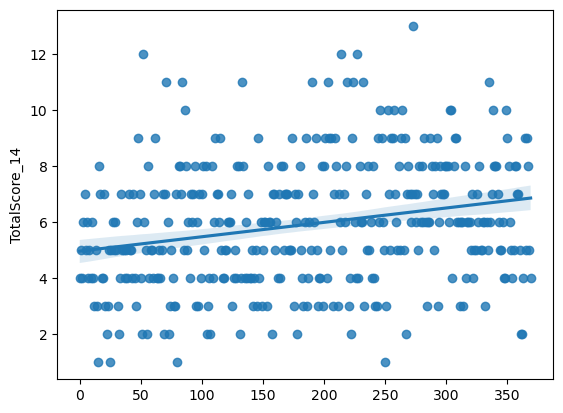

In [93]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_14')

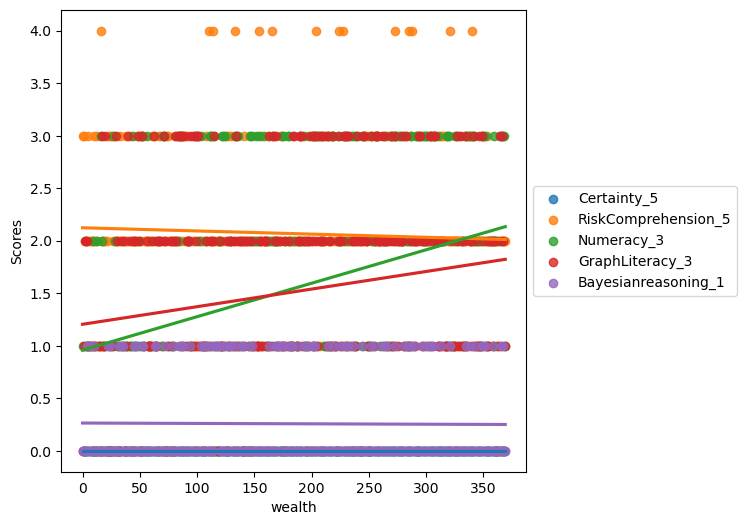

In [94]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_5', fit_reg=True, ci=None, ax=ax1, label='Certainty_5')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_5')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax1, label='Numeracy_3')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [95]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                             97
2                             91
3                             96
4                             86

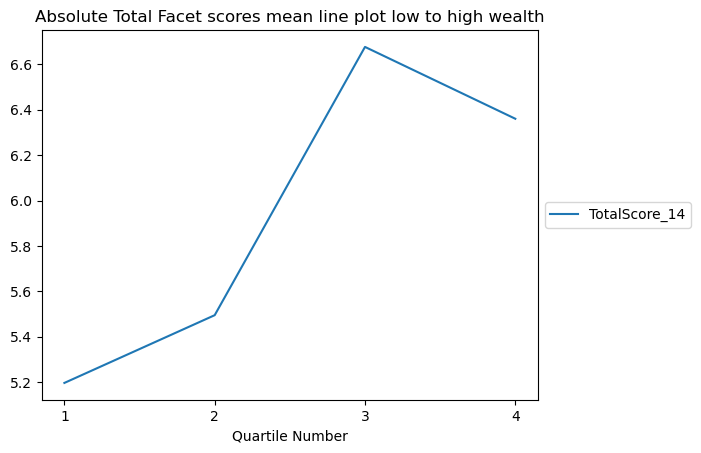

In [96]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

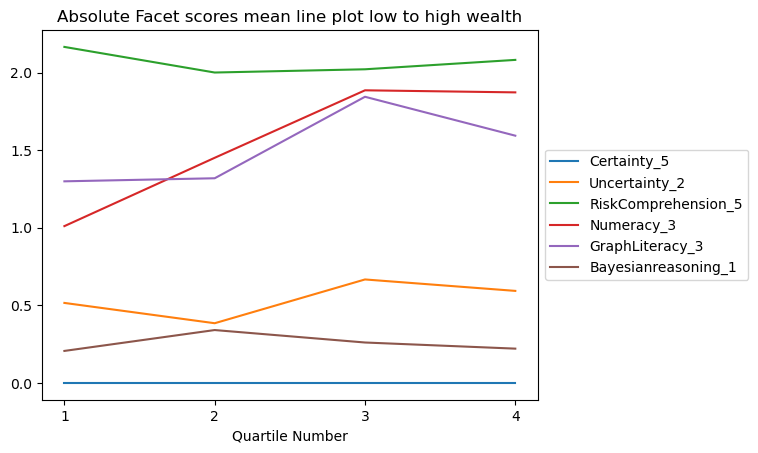

In [97]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

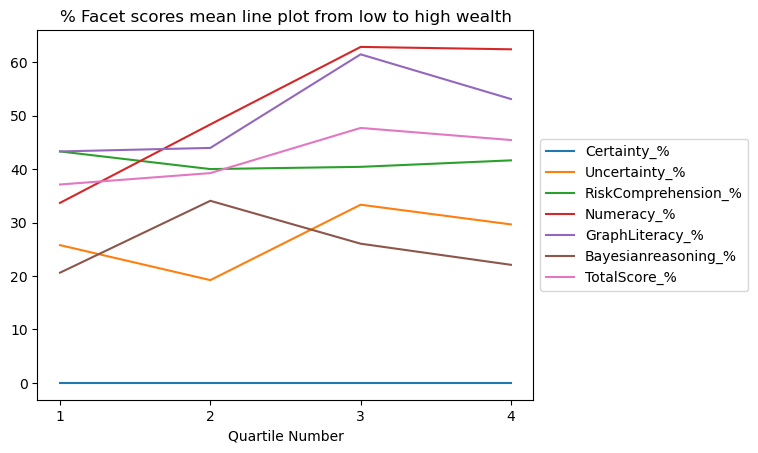

In [98]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = '% Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

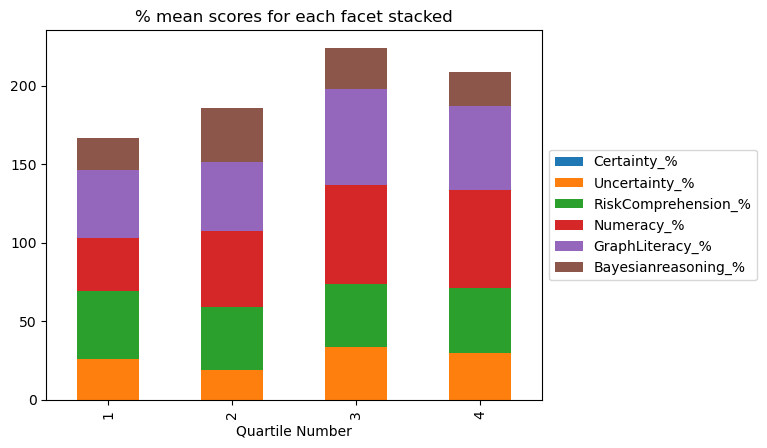

In [99]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

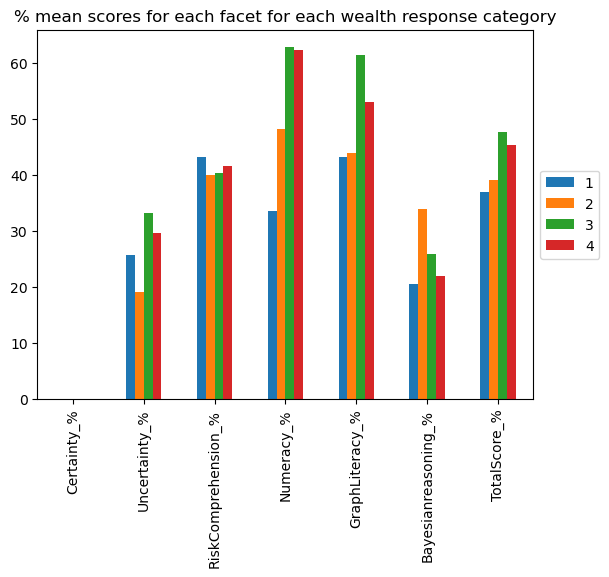

In [100]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

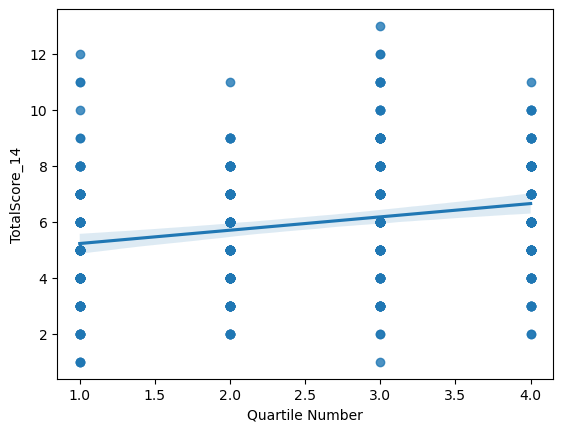

In [101]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_14')

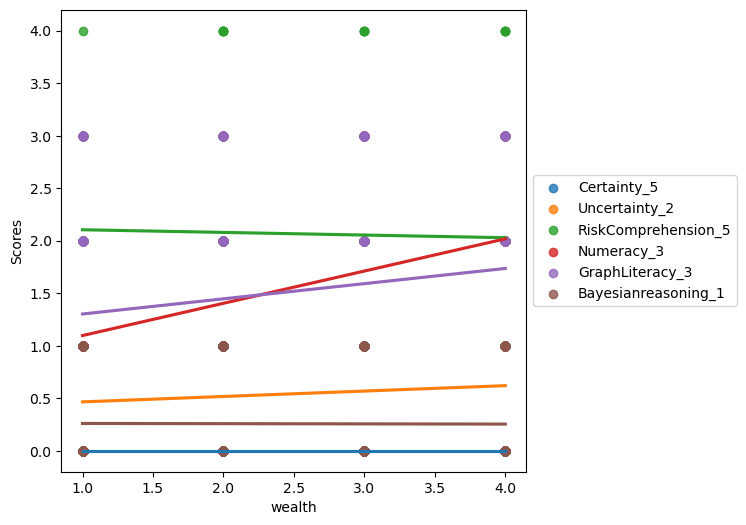

In [102]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax2, label='Certainty_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax2, label='Uncertainty_2')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

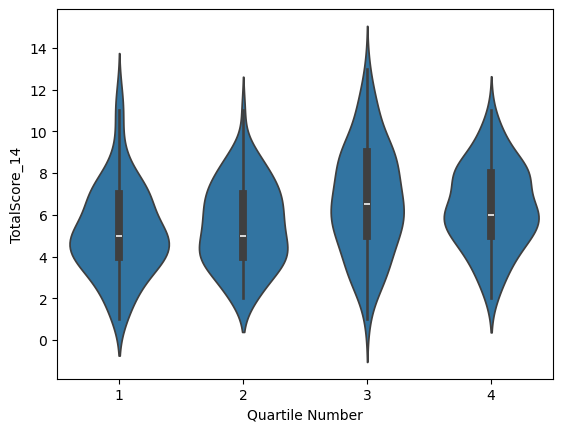

In [103]:
# Violine Plot for TotalScore_14 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_14')

<Axes: xlabel='Quartile Number', ylabel='Certainty_5'>

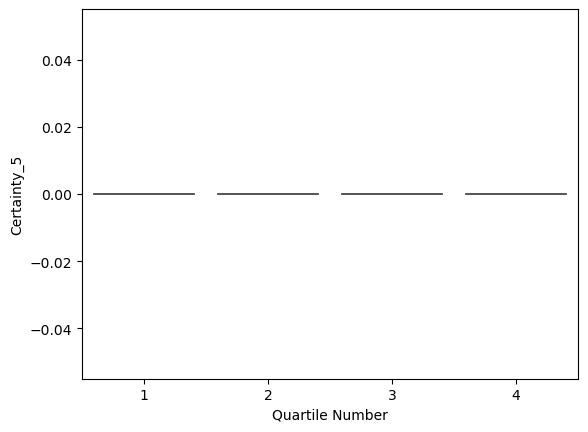

In [104]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_5')

<Axes: xlabel='Quartile Number', ylabel='Uncertainty_2'>

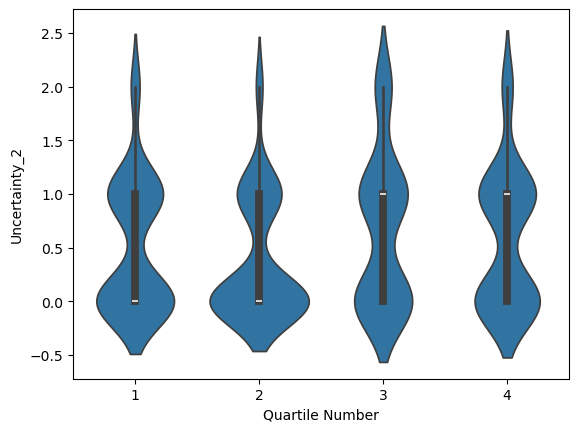

In [105]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Uncertainty_2')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_5'>

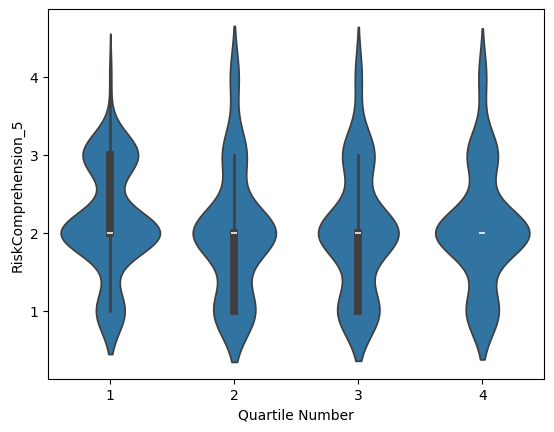

In [106]:
# Violine Plot for RiskComprehension_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_5')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

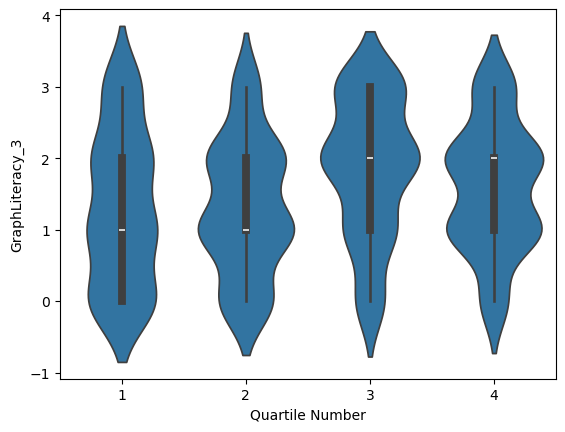

In [107]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_3'>

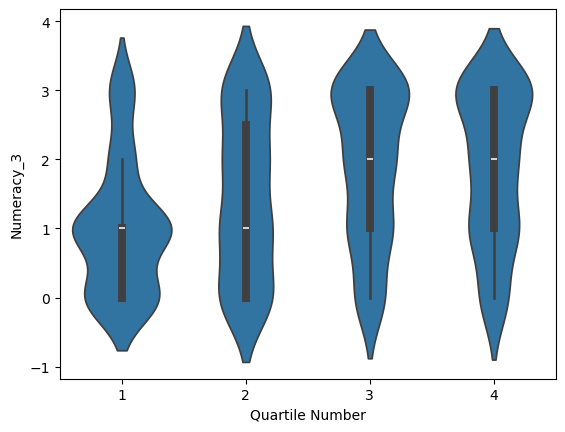

In [108]:
# Violine Plot for Numeracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_3')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

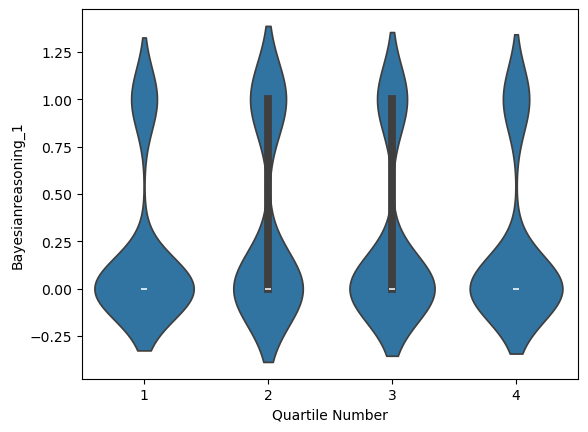

In [109]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

### WEALTH vs SCORES w/ ISCED classification

In [110]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

wealth
count  1.260000e+02
mean   2.664082e+06
std    3.496396e+06
min    2.300000e+04
25%    2.000000e+05
50%    1.000000e+06
75%    4.000000e+06
max    1.000000e+07

In [111]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  2.010000e+02
mean   2.141604e+06
std    3.253903e+06
min    2.300000e+04
25%    1.000000e+05
50%    5.000000e+05
75%    2.500000e+06
max    1.000000e+07

In [112]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  4.300000e+01
mean   1.904884e+06
std    3.043102e+06
min    2.300000e+04
25%    7.000000e+04
50%    4.000000e+05
75%    1.750000e+06
max    1.000000e+07

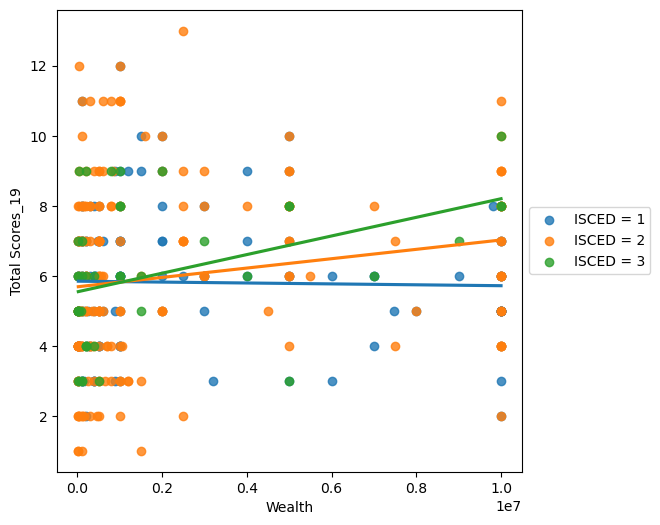

In [113]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

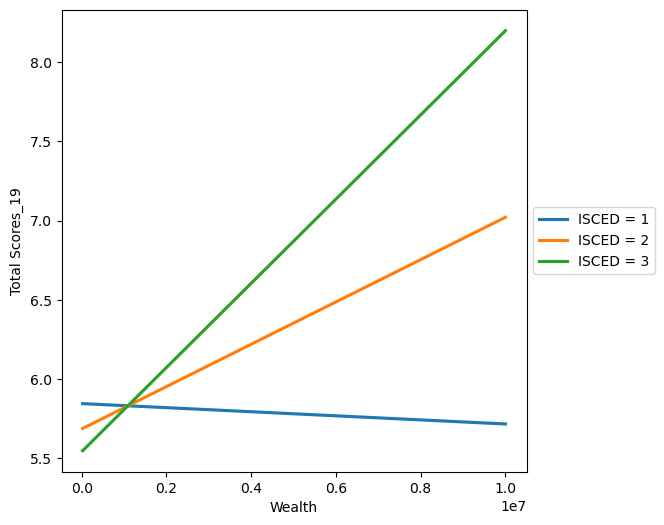

In [114]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

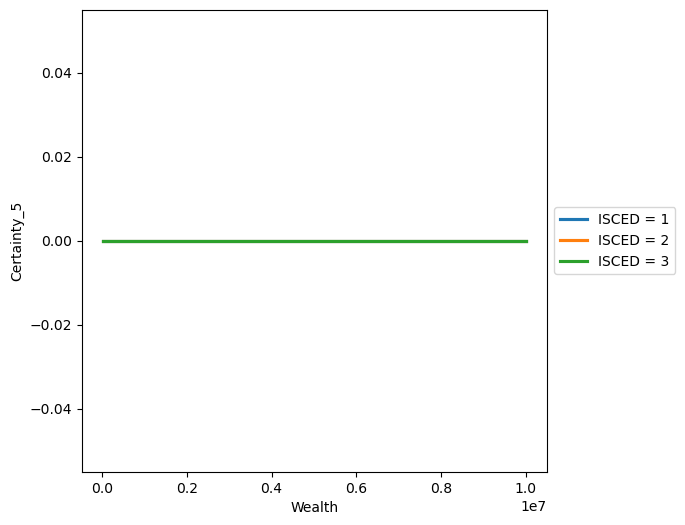

In [115]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

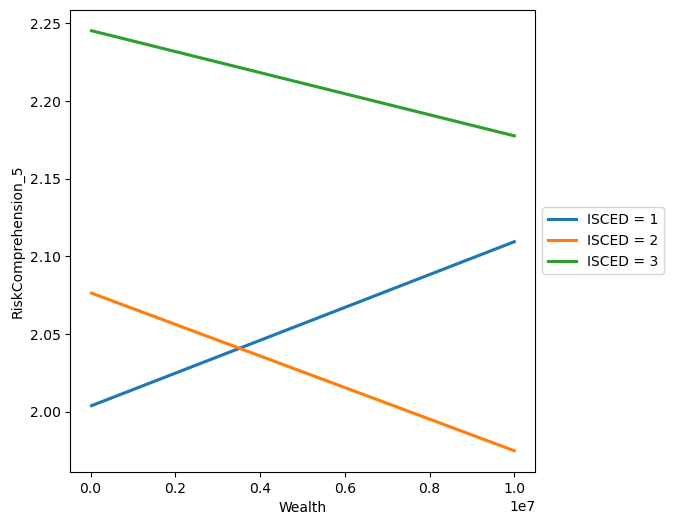

In [116]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

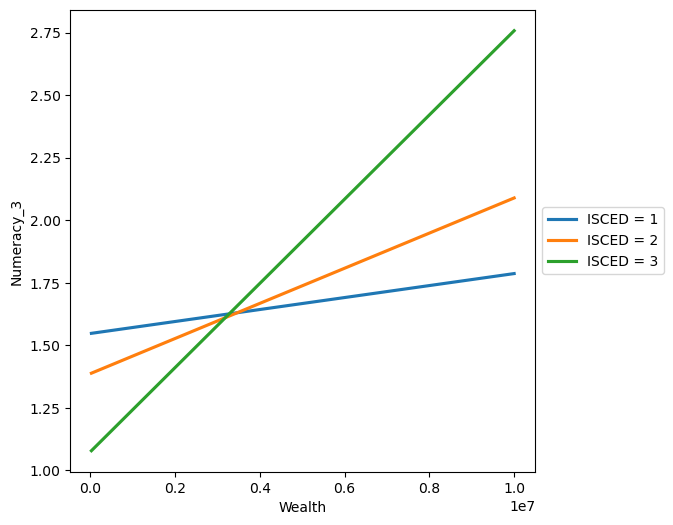

In [117]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

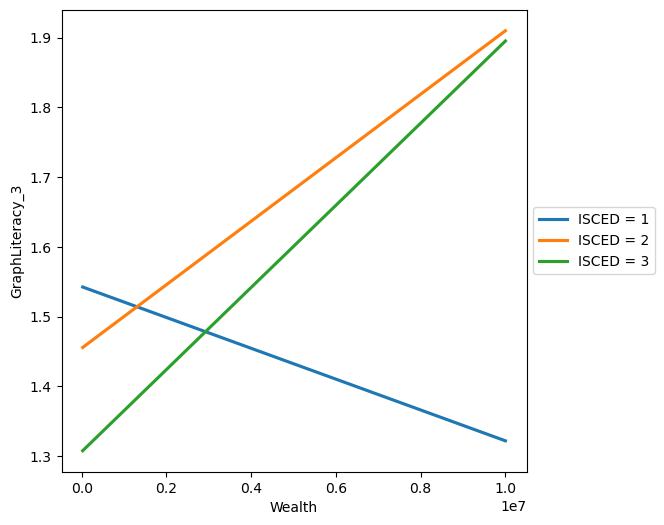

In [118]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

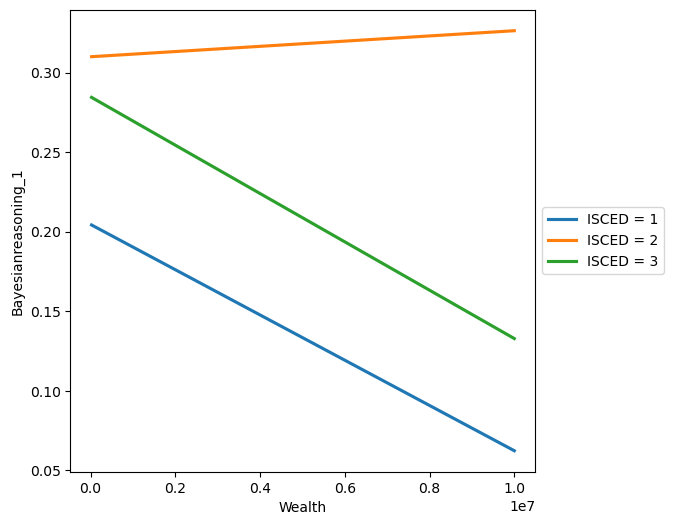

In [119]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### WEALTH Quartile Number vs SCORES w/ ISCED and AGE based classification

In [120]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df4.loc[df4['isced']==1].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  126.000000  126.000000  126.0  126.000000  1.260000e+02        126.0   
mean    33.087302    2.357143    1.0    1.873016  2.664082e+06          0.0   
std      9.354374    0.558058    0.0    1.042951  3.496396e+06          0.0   
min     18.000000    2.000000    1.0    1.000000  2.300000e+04          0.0   
25%     27.000000    2.000000    1.0    1.000000  2.000000e+05          0.0   
50%     31.000000    2.000000    1.0    2.000000  1.000000e+06          0.0   
75%     37.000000    3.000000    1.0    2.000000  4.000000e+06          0.0   
max     70.000000    4.000000    1.0    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     126.000000           126.000000       126.000000  126.000000   
mean        0.515873             2.031746         1.484127    1.611111   
std         0.629083             0.714832         0.952757    1.058091   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             2.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           126.000000        126.0     126.000000           126.000000   
mean              0.166667          0.0      25.793651            40.634921   
std               0.374166          0.0      31.454174            14.296631   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               0.000000          0.0      50.000000            40.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       126.000000  126.000000           126.000000     126.000000   
mean         49.470899   53.703704            16.666667       5.809524   
std          31.758569   35.269684            37.416574       1.950238   
min           0.000000    0.000000             0.000000       2.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max         100.000000  100.000000           100.000000      12.000000   

       TotalScore_%  Quartile Number  
count    126.000000       126.000000  
mean      41.496599         2.611111  
std       13.930272         1.116940  
min       14.285714         1.000000  
25%       28.571429         2.000000  
50%       42.857143         3.000000  
75%       50.000000         4.000000  
max       85.714286         4.000000

In [121]:
df4.loc[df4['isced']==2].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  201.000000  201.000000  201.0  201.000000  2.010000e+02        201.0   
mean    27.716418    2.144279    2.0    1.686567  2.141604e+06          0.0   
std      8.642579    0.405067    0.0    1.008102  3.253903e+06          0.0   
min     18.000000    2.000000    2.0    1.000000  2.300000e+04          0.0   
25%     22.000000    2.000000    2.0    1.000000  1.000000e+05          0.0   
50%     25.000000    2.000000    2.0    1.000000  5.000000e+05          0.0   
75%     31.000000    2.000000    2.0    2.000000  2.500000e+06          0.0   
max     70.000000    4.000000    2.0    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     201.000000           201.000000       201.000000  201.000000   
mean        0.512438             2.054726         1.552239    1.537313   
std         0.633320             0.801243         1.033686    1.153192   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         0.000000             2.000000         2.000000    1.000000   
75%         1.000000             3.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           201.000000        201.0     201.000000           201.000000   
mean              0.313433          0.0      25.621891            41.094527   
std               0.465047          0.0      31.666012            16.024856   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               1.000000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       201.000000  201.000000           201.000000     201.000000   
mean         51.741294   51.243781            31.343284       5.970149   
std          34.456212   38.439718            46.504694       2.517758   
min           0.000000    0.000000             0.000000       1.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          66.666667   33.333333             0.000000       6.000000   
75%          66.666667  100.000000           100.000000       8.000000   
max         100.000000  100.000000           100.000000      13.000000   

       TotalScore_%  Quartile Number  
count    201.000000       201.000000  
mean      42.643923         2.402985  
std       17.983984         1.096262  
min        7.142857         1.000000  
25%       28.571429         1.000000  
50%       42.857143         2.000000  
75%       57.142857         3.000000  
max       92.857143         4.000000

In [122]:
df4.loc[df4['isced']==3].describe()

age    age_rec  isced     income        wealth  Certainty_5  \
count  43.000000  43.000000   43.0  43.000000  4.300000e+01         43.0   
mean   22.255814   2.046512    3.0   1.767442  1.904884e+06          0.0   
std     6.959382   0.433891    0.0   1.250471  3.043102e+06          0.0   
min    16.000000   0.000000    3.0   1.000000  2.300000e+04          0.0   
25%    18.000000   2.000000    3.0   1.000000  7.000000e+04          0.0   
50%    19.000000   2.000000    3.0   1.000000  4.000000e+05          0.0   
75%    22.000000   2.000000    3.0   2.000000  1.750000e+06          0.0   
max    46.000000   3.000000    3.0   5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count      43.000000            43.000000        43.000000   43.000000   
mean        0.744186             2.232558         1.418605    1.395349   
std         0.693268             0.684426         0.879192    1.217717   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    0.000000   
50%         1.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            43.000000         43.0      43.000000            43.000000   
mean              0.255814          0.0      37.209302            44.651163   
std               0.441481          0.0      34.663387            13.688514   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0      50.000000            40.000000   
75%               0.500000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count        43.000000   43.000000            43.000000      43.000000   
mean         47.286822   46.511628            25.581395       6.046512   
std          29.306407   40.590571            44.148145       1.987502   
min           0.000000    0.000000             0.000000       3.000000   
25%          33.333333    0.000000             0.000000       5.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000            50.000000       8.000000   
max         100.000000  100.000000           100.000000      10.000000   

       TotalScore_%  Quartile Number  
count     43.000000        43.000000  
mean      43.189369         2.302326  
std       14.196446         1.165677  
min       21.428571         1.000000  
25%       35.714286         1.000000  
50%       42.857143         2.000000  
75%       57.142857         3.000000  
max       71.428571         4.000000

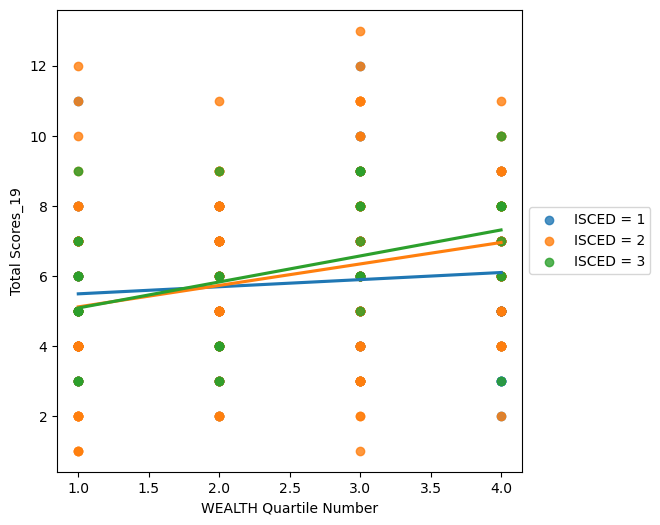

In [123]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==1]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==2]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==3]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

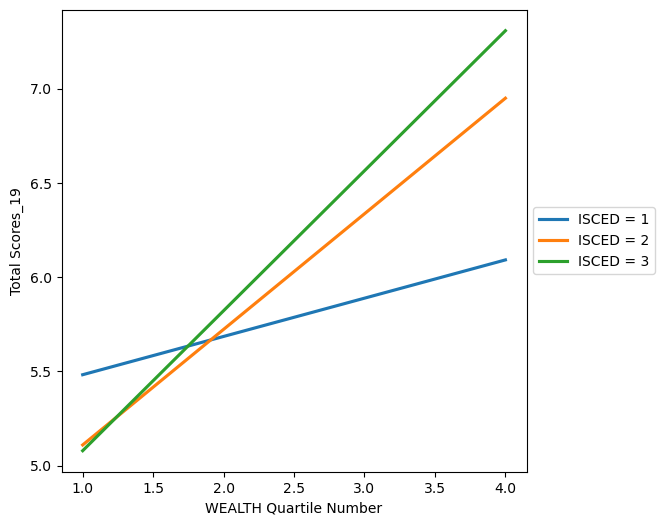

In [124]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

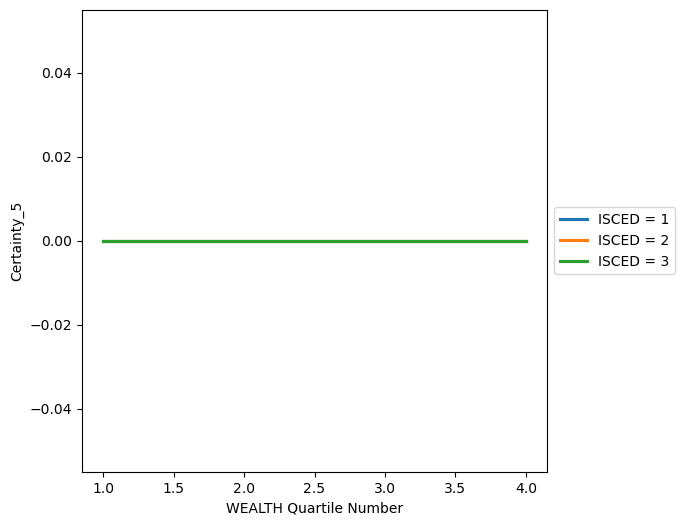

In [125]:
# Trend line for Absolute Certainty Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

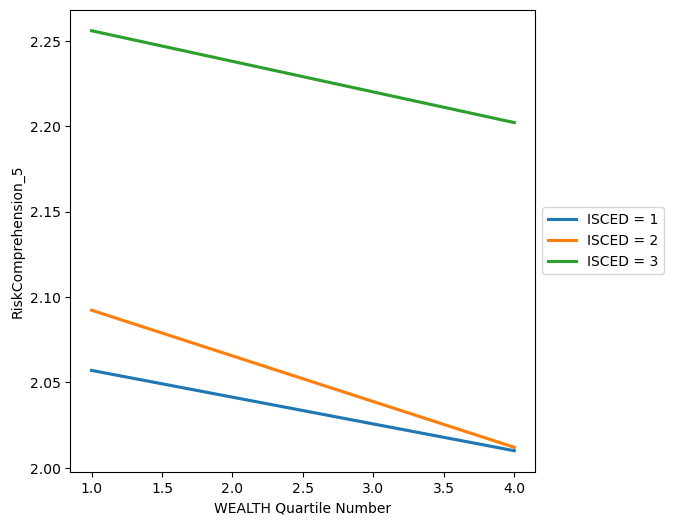

In [126]:
# Trend line for Absolute Risk Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

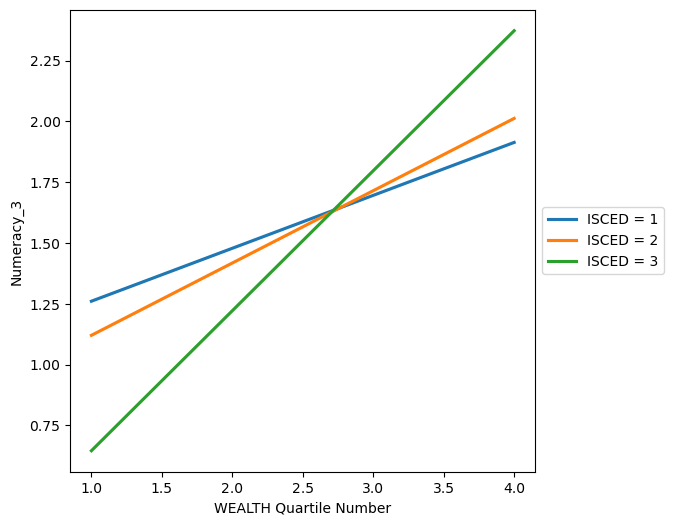

In [127]:
# Trend line for Absolute Number Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

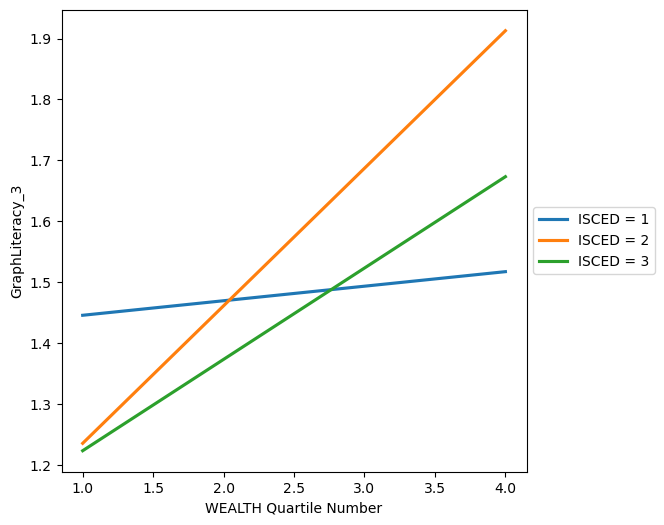

In [128]:
# Trend line for Absolute Graph Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

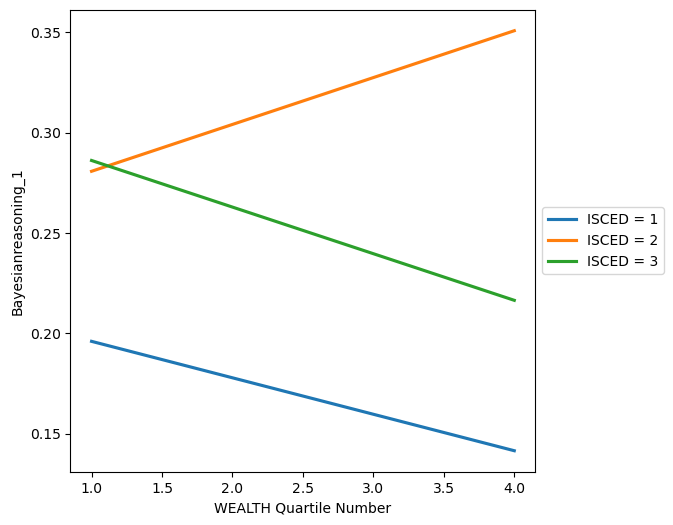

In [129]:
# Trend line for Absolute Bayesian Reasoning Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [130]:
df4

ResponseId  age  age_rec  isced  income      wealth  Certainty_5  \
0    R_4RdvJHWltLGyIlX   25        2      2       2     23000.0            0   
1    R_490q5M87aQkwYfE   21        2      3       1     23000.0            0   
2    R_49CJevI2LFJAPyV   33        2      2       1     23000.0            0   
3    R_4BXfZlfrPGt8mgt   21        2      3       1     23000.0            0   
4    R_4DPGUOAP86yO30R   19        2      3       1     23000.0            0   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4rUt2AHNjUtT3dO   25        2      2       4  10000000.0            0   
366  R_4CIa2n569811FhB   30        2      2       2  10000000.0            0   
367  R_4dn9FLQkkBnMNgq   21        2      2       1  10000000.0            0   
368  R_42Fmxo2od25B7AY   61        4      1       2  10000000.0            0   
369  R_4XgkSFVYD7YAAsS   18        2      2       3  10000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    3                0           1   
1                1                    3                1           0   
2                0                    2                2           0   
3                1                    2                2           1   
4                2                    1                2           1   
..             ...                  ...              ...         ...   
365              1                    1                2           0   
366              1                    2                3           3   
367              0                    2                2           3   
368              0                    2                0           3   
369              0                    2                1           1   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0          0.0            0.0                 60.0   
1                      0          0.0           50.0                 60.0   
2                      0          0.0            0.0                 40.0   
3                      0          0.0           50.0                 40.0   
4                      1          0.0          100.0                 20.0   
..                   ...          ...            ...                  ...   
365                    1          0.0           50.0                 20.0   
366                    0          0.0           50.0                 40.0   
367                    1          0.0            0.0                 40.0   
368                    0          0.0            0.0                 40.0   
369                    0          0.0            0.0                 40.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
0           0.000000   33.333333                  0.0              4   
1          33.333333    0.000000                  0.0              5   
2          66.666667    0.000000                  0.0              4   
3          66.666667   33.333333                  0.0              6   
4          66.666667   33.333333                100.0              7   
..               ...         ...                  ...            ...   
365        66.666667    0.000000                100.0              5   
366       100.000000  100.000000                  0.0              9   
367        66.666667  100.000000                100.0              8   
368         0.000000  100.000000                  0.0              5   
369        33.333333   33.333333                  0.0              4   

     TotalScore_%  Quartile Number  
0       28.571429                1  
1       35.714286                1  
2       28.571429                1  
3       42.857143                1  
4       50.000000                1  
..            ...              ...  
365     35.714286                4  
366     64.285714                4  
367     57.142857                4  
368     35.714286         

In [131]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [132]:
df4.loc[(df4['age_rec']==2)].describe()

age  age_rec       isced      income        wealth  Certainty_5  \
count  300.000000    300.0  300.000000  300.000000  3.000000e+02        300.0   
mean    25.443333      2.0    1.840000    1.730000  2.106699e+06          0.0   
std      4.879839      0.0    0.623723    1.042781  3.209693e+06          0.0   
min     18.000000      2.0    1.000000    1.000000  2.300000e+04          0.0   
25%     21.000000      2.0    1.000000    1.000000  1.000000e+05          0.0   
50%     25.000000      2.0    2.000000    1.000000  5.000000e+05          0.0   
75%     29.000000      2.0    2.000000    2.000000  2.500000e+06          0.0   
max     35.000000      2.0    3.000000    5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count     300.000000            300.00000       300.000000  300.000000   
mean        0.536667              2.06000         1.536667    1.536667   
std         0.655812              0.77356         0.999325    1.137086   
min         0.000000              1.00000         0.000000    0.000000   
25%         0.000000              2.00000         1.000000    1.000000   
50%         0.000000              2.00000         2.000000    1.000000   
75%         1.000000              3.00000         2.000000    3.000000   
max         2.000000              4.00000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           300.000000        300.0     300.000000           300.000000   
mean              0.273333          0.0      26.833333            41.200000   
std               0.446415          0.0      32.790593            15.471195   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               1.000000          0.0      50.000000            60.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count       300.000000  300.000000           300.000000     300.000000   
mean         51.222222   51.222222            27.333333       5.943333   
std          33.310843   37.902879            44.641518       2.354840   
min           0.000000    0.000000             0.000000       1.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          66.666667   33.333333             0.000000       6.000000   
75%          66.666667  100.000000           100.000000       8.000000   
max         100.000000  100.000000           100.000000      13.000000   

       TotalScore_%  Quartile Number  
count    300.000000       300.000000  
mean      42.452381         2.403333  
std       16.820288         1.094524  
min        7.142857         1.000000  
25%       28.571429         1.000000  
50%       42.857143         2.000000  
75%       57.142857         3.000000  
max       92.857143         4.000000

In [133]:
df4.loc[(df4['age_rec']==3)].describe()

age  age_rec      isced     income        wealth  Certainty_5  \
count  60.000000     60.0  60.000000  60.000000  6.000000e+01         60.0   
mean   41.366667      3.0   1.483333   1.800000  2.752483e+06          0.0   
std     5.108871      0.0   0.624138   0.988064  3.469050e+06          0.0   
min    36.000000      3.0   1.000000   1.000000  2.300000e+04          0.0   
25%    37.000000      3.0   1.000000   1.000000  1.500000e+05          0.0   
50%    40.000000      3.0   1.000000   2.000000  1.000000e+06          0.0   
75%    44.000000      3.0   2.000000   2.000000  5.000000e+06          0.0   
max    54.000000      3.0   3.000000   5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count      60.000000            60.000000        60.000000   60.000000   
mean        0.583333             2.066667         1.450000    1.533333   
std         0.590652             0.709898         0.946447    1.111827   
min         0.000000             1.000000         0.000000    0.000000   
25%         0.000000             2.000000         1.000000    1.000000   
50%         1.000000             2.000000         1.000000    1.000000   
75%         1.000000             2.000000         2.000000    3.000000   
max         2.000000             4.000000         3.000000    3.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            60.000000         60.0      60.000000            60.000000   
mean              0.183333          0.0      29.166667            41.333333   
std               0.390205          0.0      29.532611            14.197955   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0      50.000000            40.000000   
75%               0.000000          0.0      50.000000            40.000000   
max               1.000000          0.0     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count        60.000000   60.000000            60.000000      60.000000   
mean         48.333333   51.111111            18.333333       5.816667   
std          31.548247   37.060884            39.020493       1.987176   
min           0.000000    0.000000             0.000000       2.000000   
25%          33.333333   33.333333             0.000000       4.000000   
50%          33.333333   33.333333             0.000000       6.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max         100.000000  100.000000           100.000000      11.000000   

       TotalScore_%  Quartile Number  
count     60.000000        60.000000  
mean      41.547619         2.633333  
std       14.194117         1.163960  
min       14.285714         1.000000  
25%       28.571429         2.000000  
50%       42.857143         3.000000  
75%       50.000000         4.000000  
max       78.571429         4.000000

In [134]:
df4.loc[(df4['age_rec']==4)].describe()

age  age_rec     isced    income        wealth  Certainty_5  \
count   9.000000      9.0  9.000000  9.000000  9.000000e+00          9.0   
mean   62.888889      4.0  1.444444  2.555556  5.651667e+06          0.0   
std     4.567397      0.0  0.527046  1.509231  4.226837e+06          0.0   
min    57.000000      4.0  1.000000  1.000000  3.500000e+05          0.0   
25%    61.000000      4.0  1.000000  2.000000  5.500000e+05          0.0   
50%    61.000000      4.0  1.000000  2.000000  7.000000e+06          0.0   
75%    65.000000      4.0  2.000000  3.000000  1.000000e+07          0.0   
max    70.000000      4.0  2.000000  5.000000  1.000000e+07          0.0   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
count       9.000000             9.000000         9.000000         9.0   
mean        0.333333             2.222222         1.333333         2.0   
std         0.500000             0.666667         0.866025         1.0   
min         0.000000             1.000000         0.000000         0.0   
25%         0.000000             2.000000         1.000000         2.0   
50%         0.000000             2.000000         2.000000         2.0   
75%         1.000000             3.000000         2.000000         3.0   
max         1.000000             3.000000         2.000000         3.0   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count             9.000000          9.0       9.000000             9.000000   
mean              0.222222          0.0      16.666667            44.444444   
std               0.440959          0.0      25.000000            13.333333   
min               0.000000          0.0       0.000000            20.000000   
25%               0.000000          0.0       0.000000            40.000000   
50%               0.000000          0.0       0.000000            40.000000   
75%               0.000000          0.0      50.000000            60.000000   
max               1.000000          0.0      50.000000            60.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
count         9.000000    9.000000             9.000000       9.000000   
mean         44.444444   66.666667            22.222222       6.111111   
std          28.867513   33.333333            44.095855       1.536591   
min           0.000000    0.000000             0.000000       5.000000   
25%          33.333333   66.666667             0.000000       5.000000   
50%          66.666667   66.666667             0.000000       5.000000   
75%          66.666667  100.000000             0.000000       7.000000   
max          66.666667  100.000000           100.000000       9.000000   

       TotalScore_%  Quartile Number  
count      9.000000         9.000000  
mean      43.650794         3.444444  
std       10.975648         0.881917  
min       35.714286         2.000000  
25%       35.714286         3.000000  
50%       35.714286         4.000000  
75%       50.000000         4.000000  
max       64.285714         4.000000

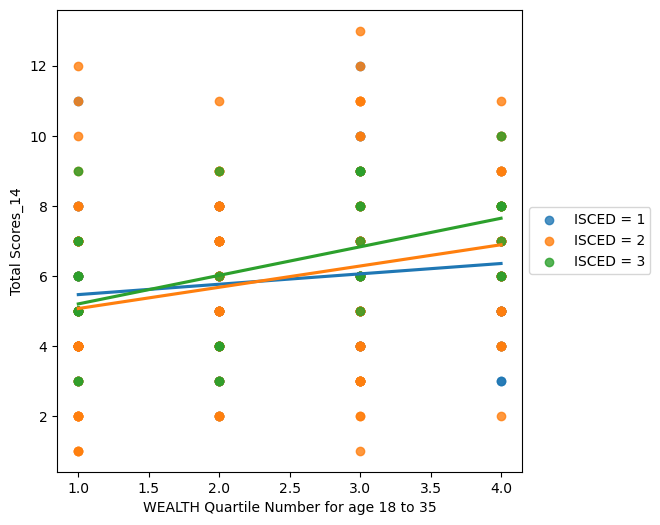

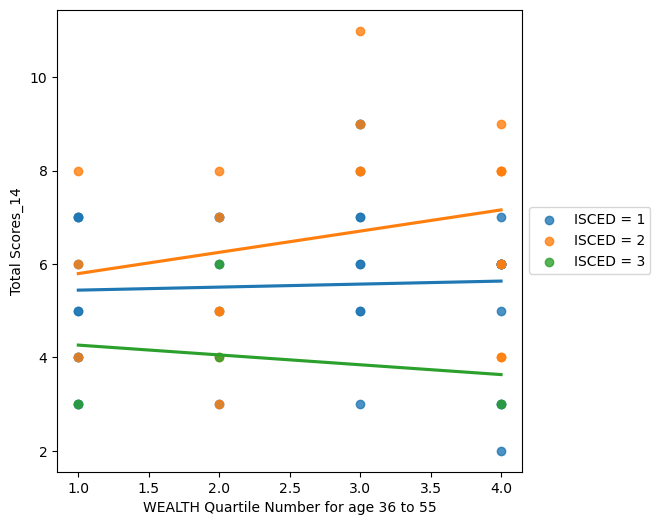

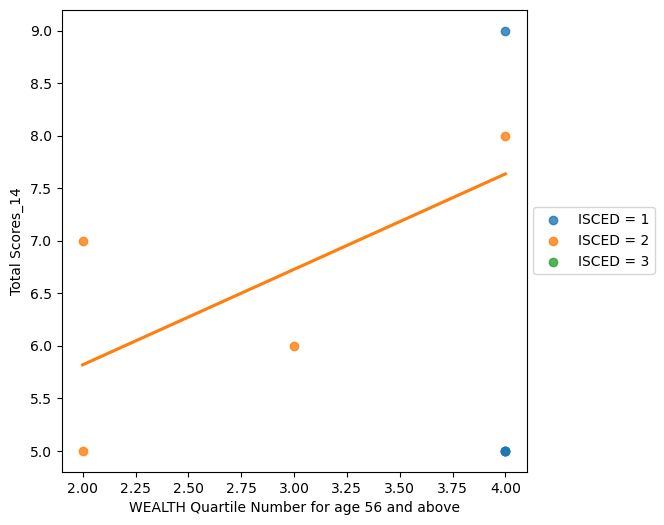

In [135]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

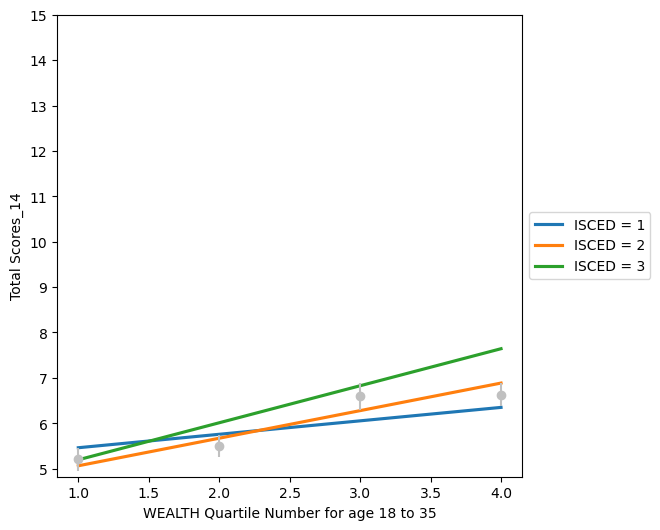

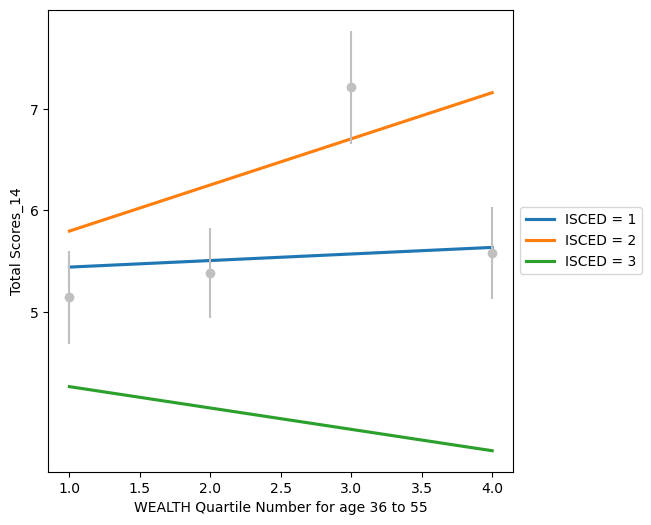

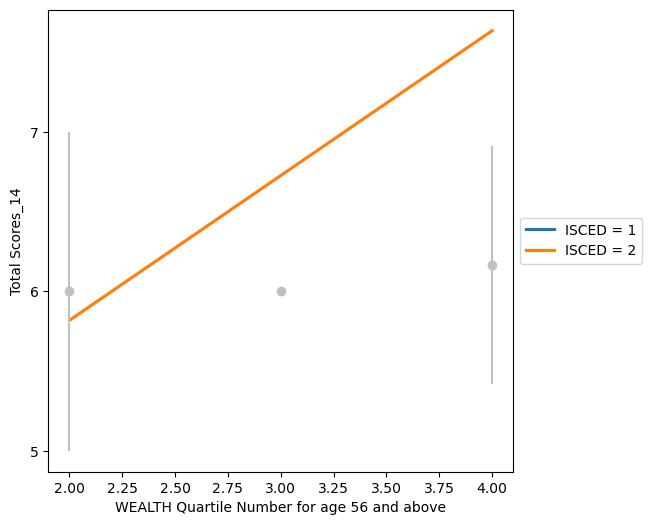

In [136]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_14'], yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_14'], yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_14'], yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

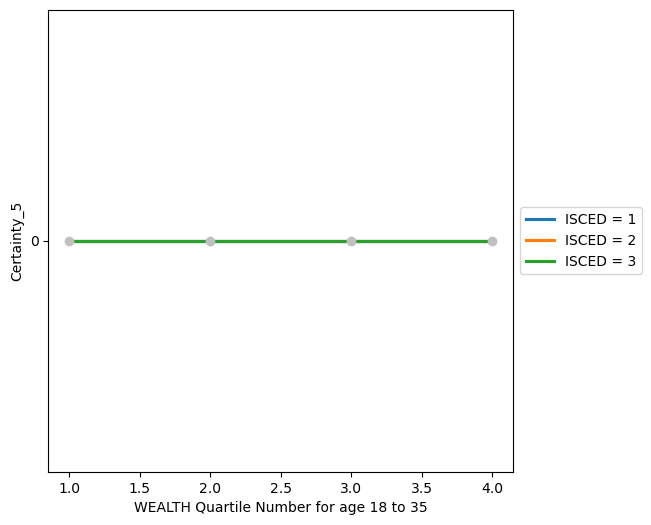

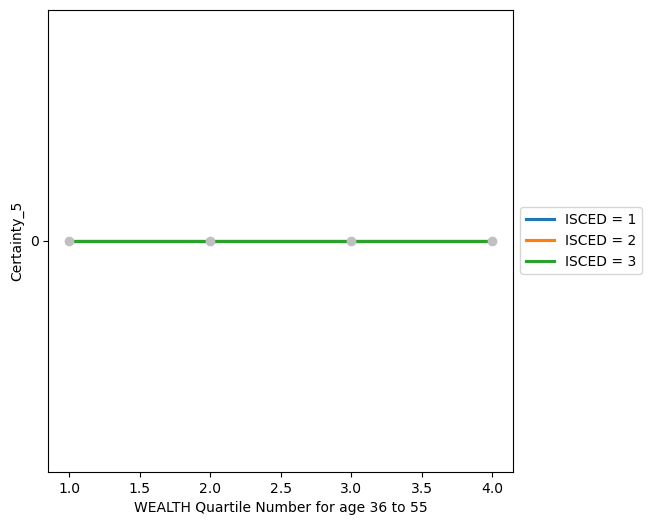

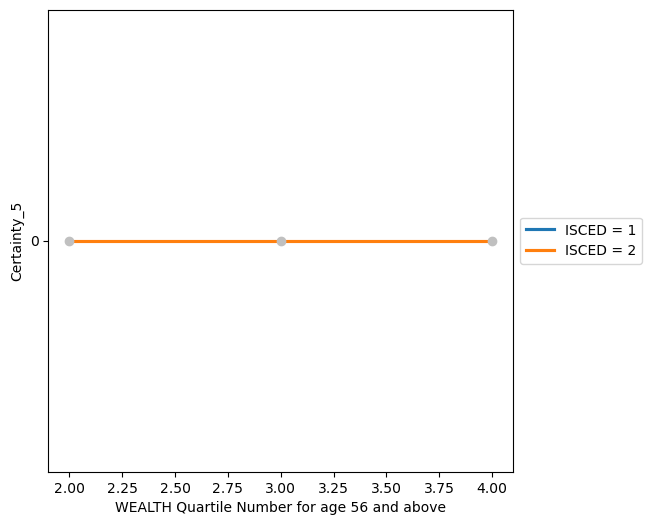

In [137]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

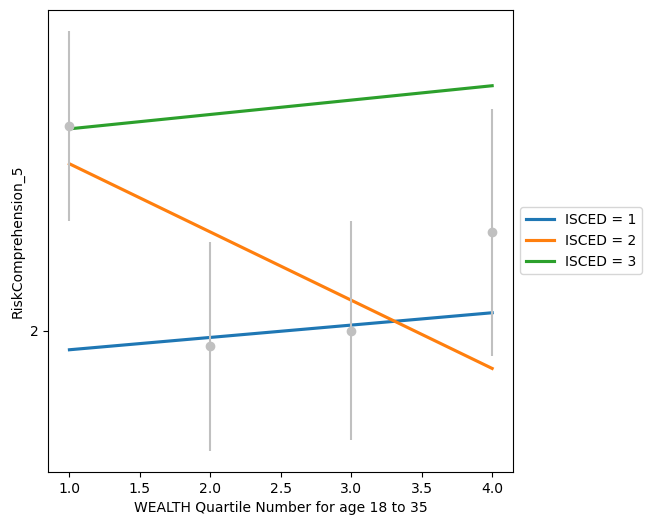

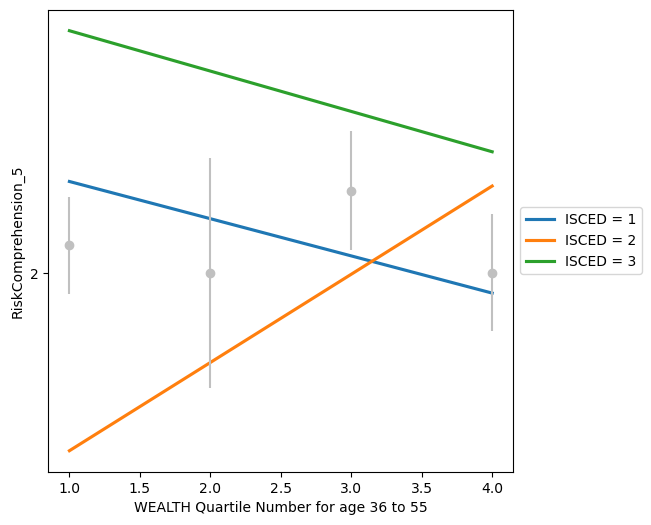

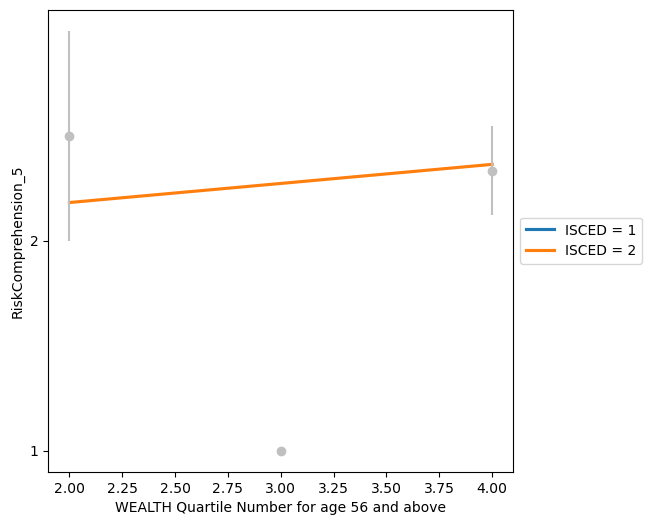

In [138]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

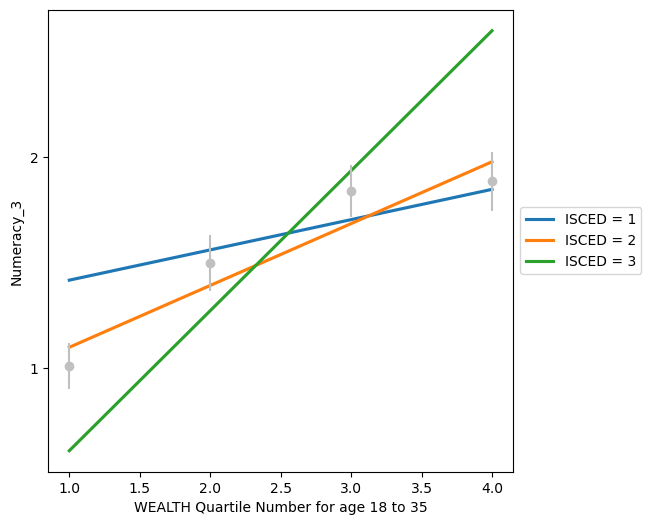

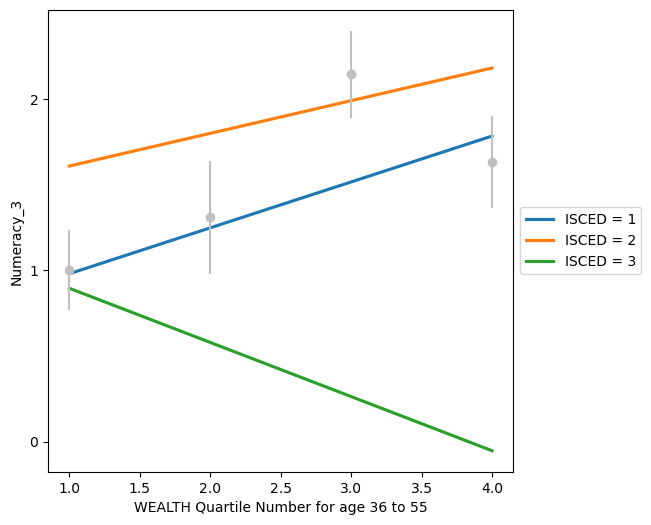

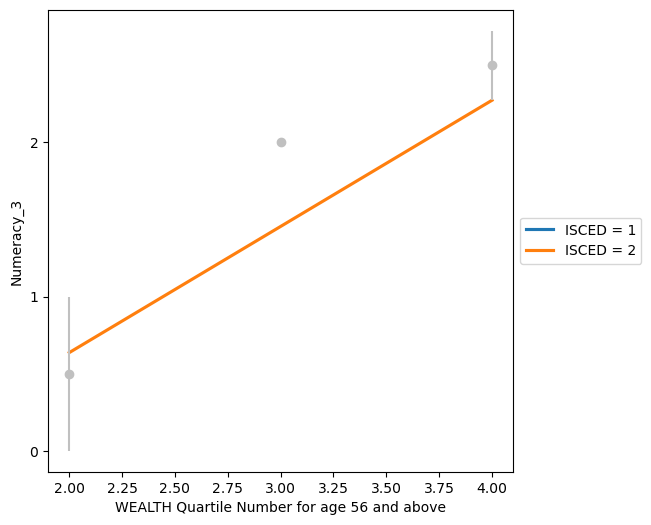

In [139]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

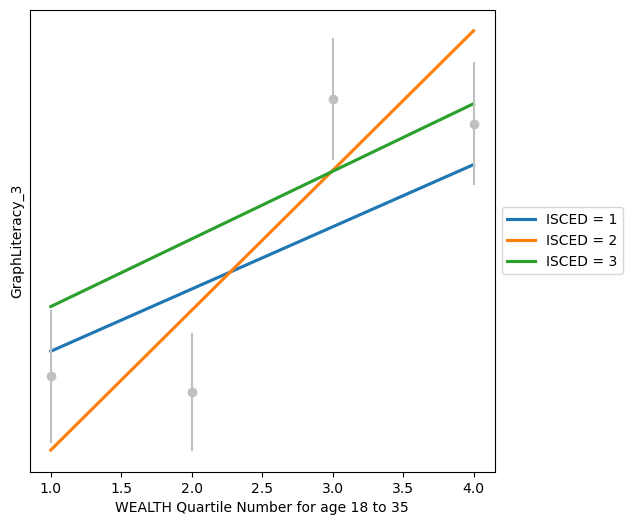

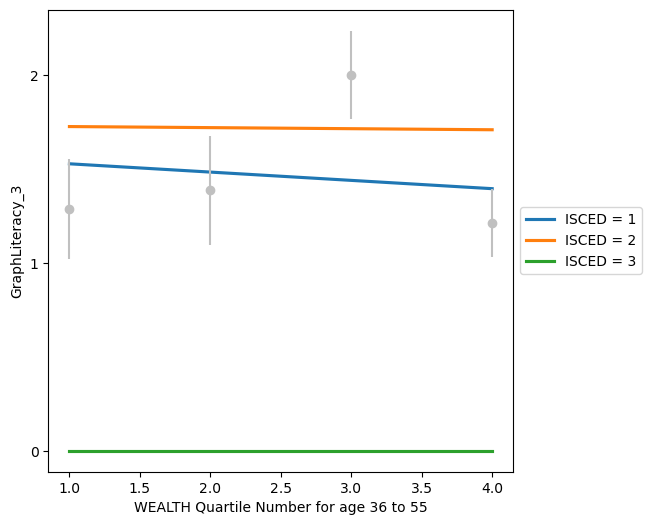

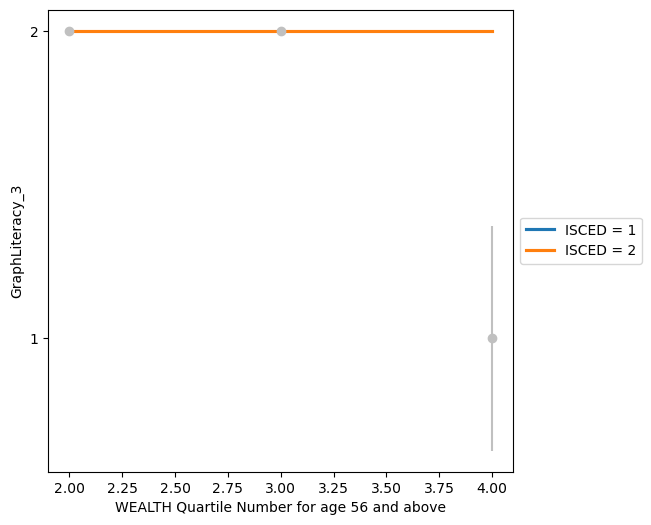

In [140]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

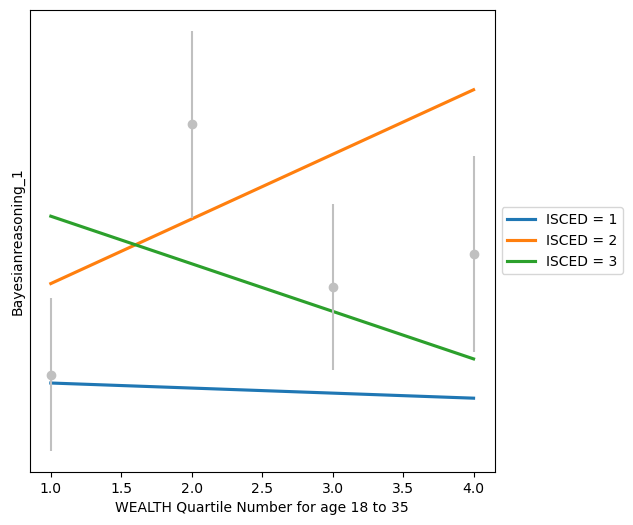

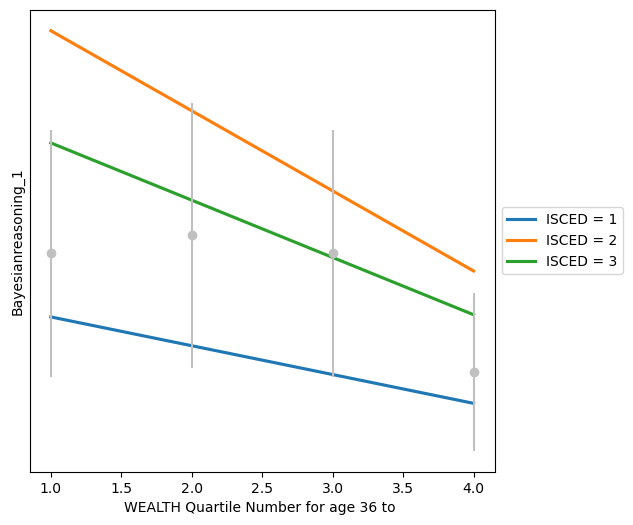

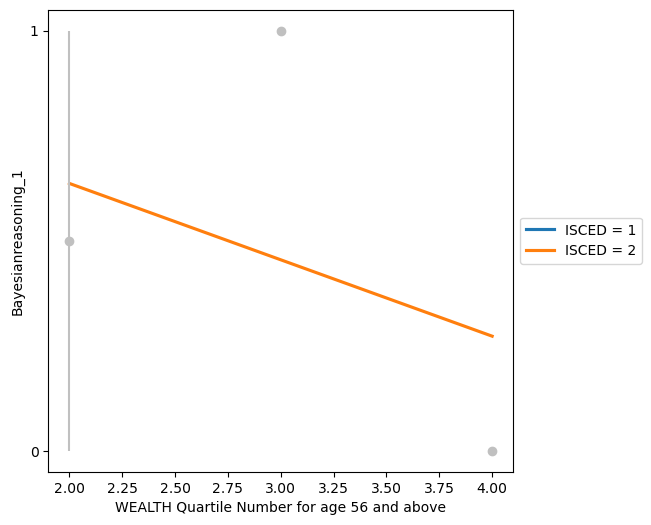

In [141]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [142]:
# Age mean method
# Age_mean

In [143]:
age_m = df2["age"].median()
age_m

27.0

In [144]:
df4["Quartile Number"].value_counts()

Quartile Number
1    97
3    96
2    91
4    86
Name: count, dtype: int64

In [145]:
df4.loc[(df4['age'] < age_m)].describe()

age     age_rec       isced      income        wealth  \
count  175.000000  175.000000  175.000000  175.000000  1.750000e+02   
mean    21.868571    1.988571    2.034286    1.685714  2.013478e+06   
std      2.586411    0.151186    0.614921    1.082022  3.214242e+06   
min     16.000000    0.000000    1.000000    1.000000  2.300000e+04   
25%     20.000000    2.000000    2.000000    1.000000  1.000000e+05   
50%     22.000000    2.000000    2.000000    1.000000  5.000000e+05   
75%     24.000000    2.000000    2.000000    2.000000  1.800000e+06   
max     26.000000    2.000000    3.000000    5.000000  1.000000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count        175.0     175.000000           175.000000       175.000000   
mean           0.0       0.548571             2.068571         1.497143   
std            0.0       0.666683             0.777474         0.964152   
min            0.0       0.000000             1.000000         0.000000   
25%            0.0       0.000000             2.000000         1.000000   
50%            0.0       0.000000             2.000000         2.000000   
75%            0.0       1.000000             3.000000         2.000000   
max            0.0       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  175.000000           175.000000        175.0     175.000000   
mean     1.577143             0.320000          0.0      27.428571   
std      1.136410             0.467815          0.0      33.334154   
min      0.000000             0.000000          0.0       0.000000   
25%      1.000000             0.000000          0.0       0.000000   
50%      2.000000             0.000000          0.0       0.000000   
75%      3.000000             1.000000          0.0      50.000000   
max      3.000000             1.000000          0.0     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           175.000000       175.000000  175.000000           175.000000   
mean             41.371429        49.904762   52.571429            32.000000   
std              15.549487        32.138407   37.880346            46.781468   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333   33.333333             0.000000   
50%              40.000000        66.666667   66.666667             0.000000   
75%              60.000000        66.666667  100.000000           100.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_14  TotalScore_%  Quartile Number  
count     175.000000    175.000000       175.000000  
mean        6.011429     42.938776         2.342857  
std         2.339045     16.707467         1.102319  
min         1.000000      7.142857         1.000000  
25%         4.000000     28.571429         1.000000  
50%         6.000000     42.857143         2.000000  
75%         8.000000     57.142857         3.000000  
max        12.000000     85.714286         4.000000

In [146]:
df4.loc[(df4['age'] >= age_m)].describe()

age     age_rec       isced      income        wealth  \
count  195.000000  195.000000  195.000000  195.000000  1.950000e+02   
mean    35.230769    2.400000    1.543590    1.825641  2.541990e+06   
std      8.695483    0.577945    0.567048    1.020592  3.397719e+06   
min     27.000000    2.000000    1.000000    1.000000  2.300000e+04   
25%     29.000000    2.000000    1.000000    1.000000  1.825000e+05   
50%     33.000000    2.000000    2.000000    2.000000  8.000000e+05   
75%     38.000000    3.000000    2.000000    2.000000  4.250000e+06   
max     70.000000    4.000000    3.000000    5.000000  1.000000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count        195.0     195.000000           195.000000       195.000000   
mean           0.0       0.533333             2.066667         1.528205   
std            0.0       0.619833             0.746584         1.011773   
min            0.0       0.000000             1.000000         0.000000   
25%            0.0       0.000000             2.000000         1.000000   
50%            0.0       0.000000             2.000000         2.000000   
75%            0.0       1.000000             2.000000         2.000000   
max            0.0       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  195.000000            195.00000        195.0     195.000000   
mean     1.517949              0.20000          0.0      26.666667   
std      1.123065              0.40103          0.0      30.991630   
min      0.000000              0.00000          0.0       0.000000   
25%      1.000000              0.00000          0.0       0.000000   
50%      1.000000              0.00000          0.0       0.000000   
75%      3.000000              0.00000          0.0      50.000000   
max      3.000000              1.00000          0.0     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           195.000000       195.000000  195.000000            195.00000   
mean             41.333333        50.940171   50.598291             20.00000   
std              14.931689        33.725772   37.435487             40.10296   
min              20.000000         0.000000    0.000000              0.00000   
25%              40.000000        33.333333   33.333333              0.00000   
50%              40.000000        66.666667   33.333333              0.00000   
75%              40.000000        66.666667  100.000000              0.00000   
max              80.000000       100.000000  100.000000            100.00000   

       TotalScore_14  TotalScore_%  Quartile Number  
count     195.000000    195.000000       195.000000  
mean        5.846154     41.758242         2.569231  
std         2.221480     15.867712         1.116455  
min         1.000000      7.142857         1.000000  
25%         4.000000     28.571429         2.000000  
50%         6.000000     42.857143         3.000000  
75%         7.000000     50.000000         4.000000  
max        13.000000     92.857143         4.000000

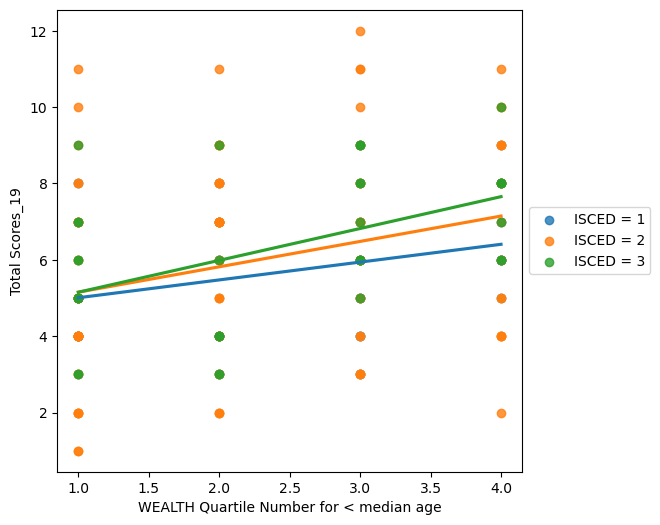

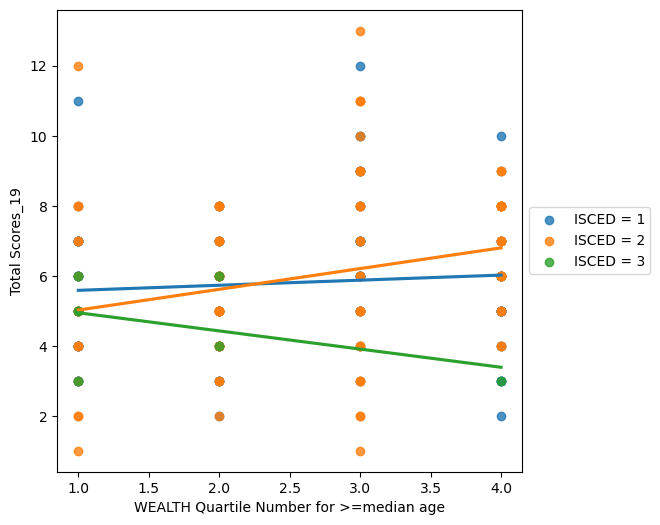

In [147]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] >= age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

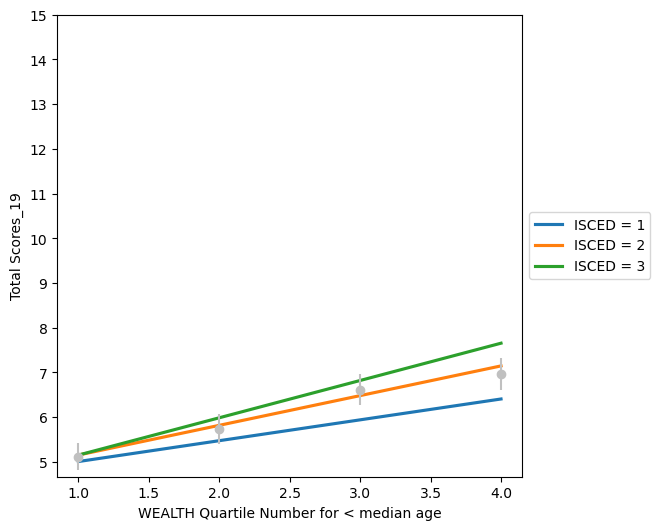

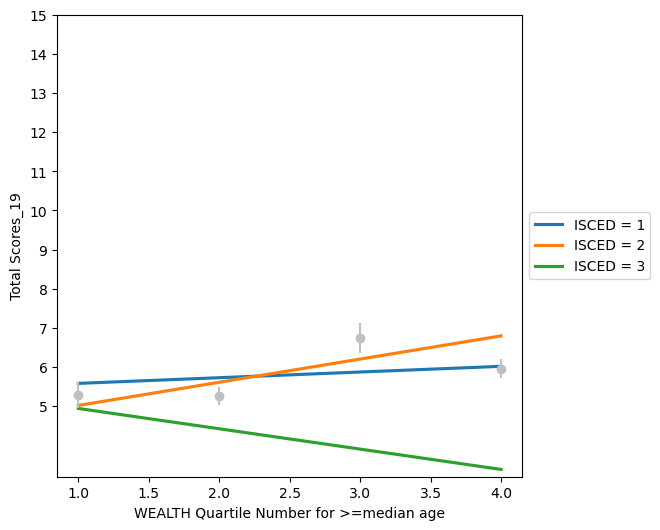

In [148]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['TotalScore_14'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['TotalScore_14'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

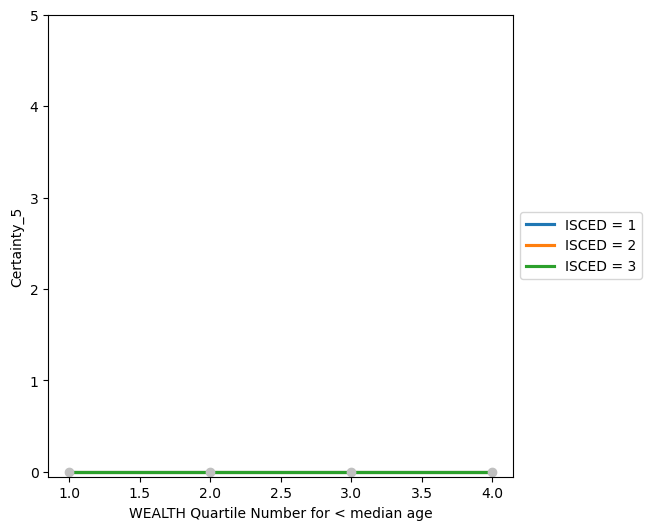

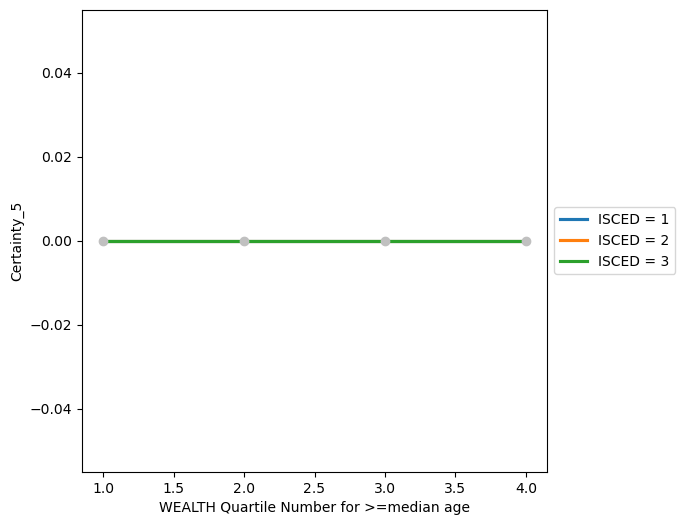

In [149]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

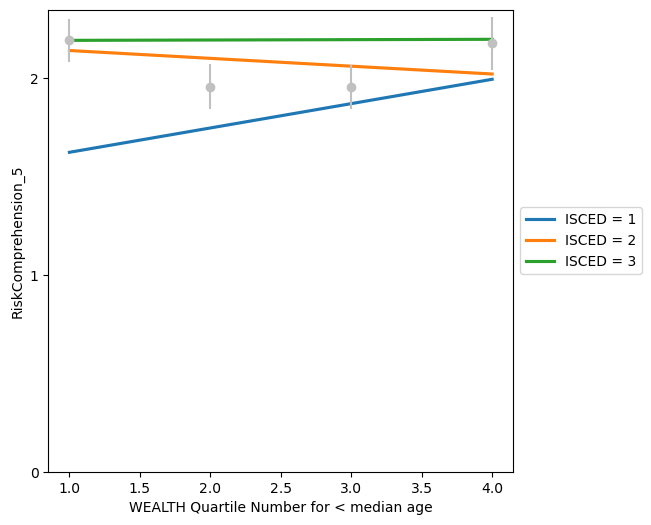

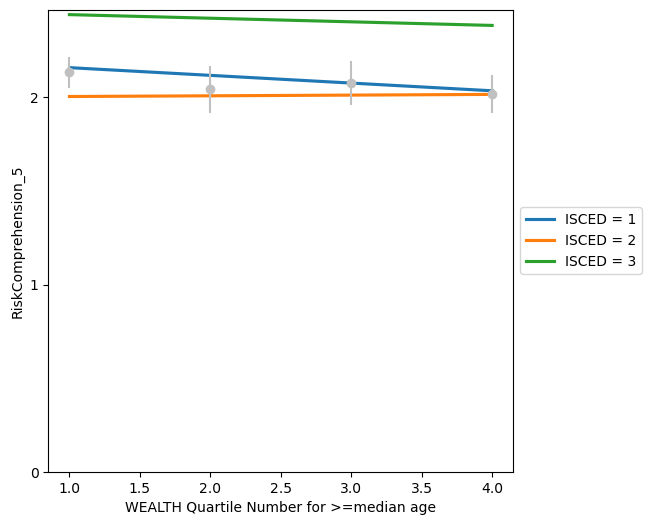

In [150]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

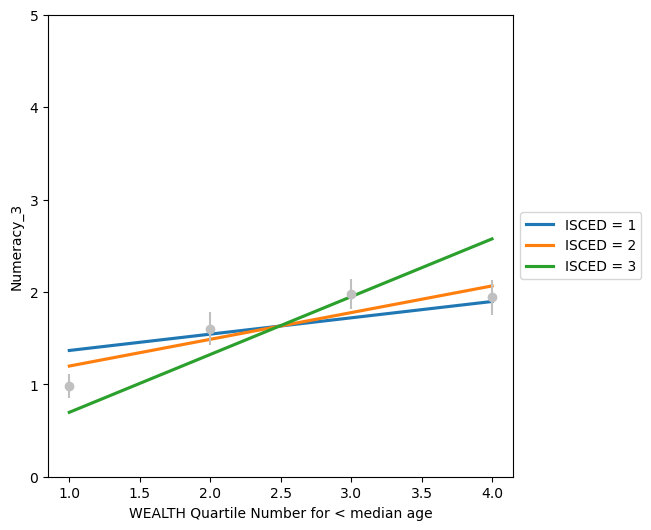

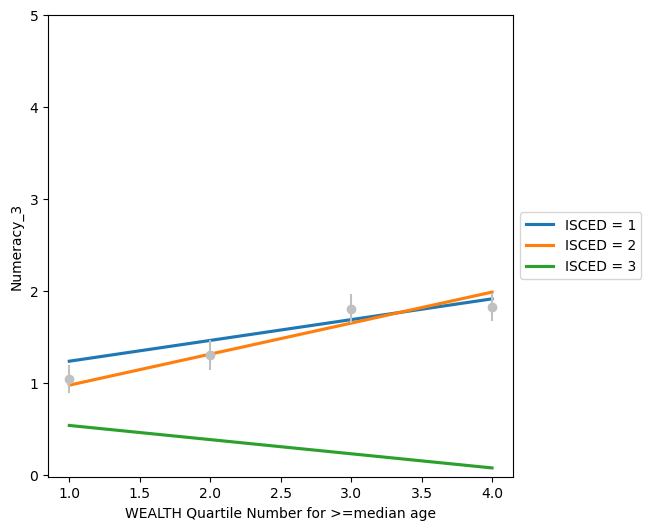

In [151]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

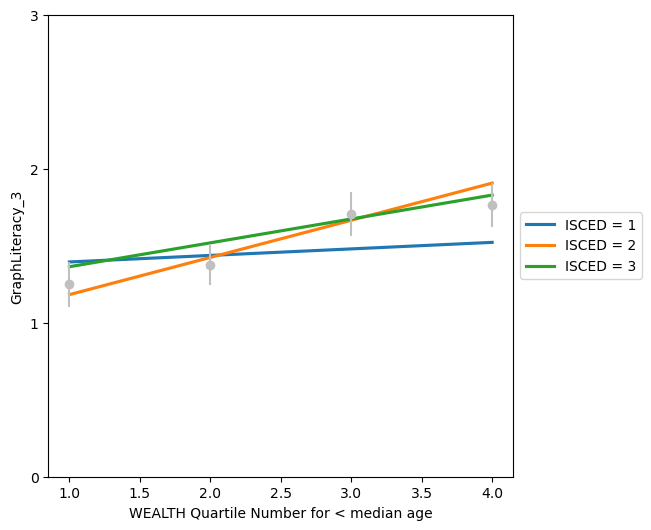

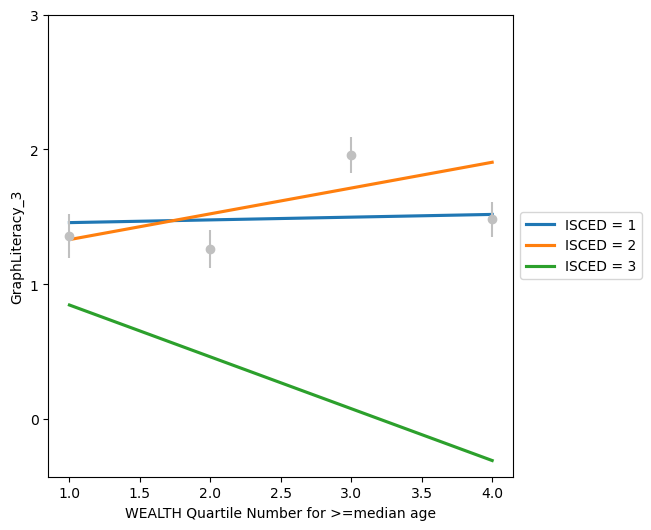

In [152]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

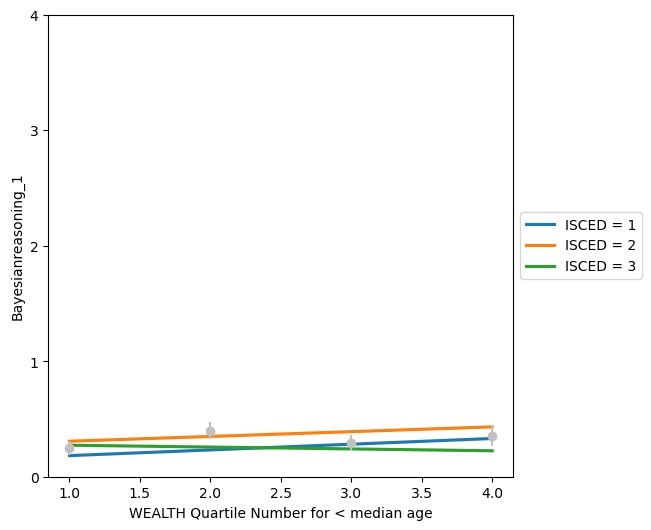

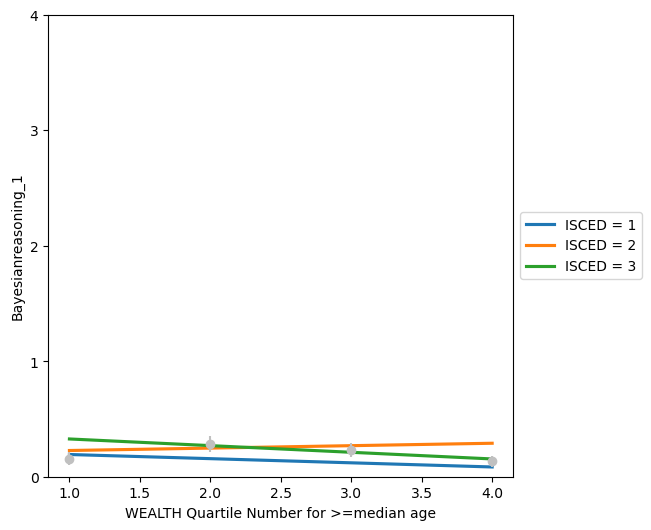

In [153]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()